In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import scipy.optimize as spo
import scipy.interpolate as spi
import cPickle as pickle
import portalocker
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import shutil, shelve
import tarfile
import time
import itertools as it
import matplotlib.lines as mlines
import matplotlib as mpl

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set(color_codes=True)
sns.set_context('talk', font_scale=1.75)
sns.set_palette("hls", 9)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

Loading Mechanical Network Deformation Solver Module


In [2]:
t0 = time.time()

# directory = "/data1/home/rocks/data/sat_transition/tune_cont_global_1D/"
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_1D/"
# tr_solver = exact, tol = sqrt(eps)
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_exact/"
# tr_solver = lsmr, tol = sqrt(eps)
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_lsmr/"
# tr_solver = lsrm, tol = sqrt(eps) / 100
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_lsmr_2/"
# tr_solver = lsrm, tol = eps
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_lsmr_3/"
# lbfgsb solver
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_lbfgsb/"
# tnc solver
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_tnc/"
# slsqp solver
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_slsqp/"


# directory = "/data1/home/rocks/data/sat_transition/tune_cont_local_2D_surface/"
# directory = "/data1/home/rocks/data/sat_transition/tune_cont_global_2D/"


#paper data


#edge source with default parameters
# name = "tune_disc_2D_edge_default"


#node pair source with default parameters
# name = "tune_disc_2D_nodepair_default"


#edge source varying constraint thresholds
# name = "tune_disc_2D_edge_constraint_thresh"

#edge source with lower DeltaZ
# name = "tune_disc_2D_edge_lower_DZ"

#edge source with triangular lattice
# name = "tune_disc_2D_edge_triangular"




#global shear source
# name = "tune_disc_2D_global_shear"

#global compression source
# name = "tune_disc_2D_global_compress"






#testing data



#single slice of edge source phase space with more system sizes
name = "tune_disc_2D_edge_slice"


# os.remove(directory+"tune_lin_db.bin.dat")

directory = "/data1/home/rocks/data/sat_transition/{}/".format(name)

print directory

files = []

print "Listing files..."

for f in os.listdir(directory):
    if f.endswith(".pkl") and f != "file_list.pkl" and  f != "tune_analysis.pkl":
        files.append(f)
        
if len(files) > 0:
        
    print "Loading..."

    db = shelve.open(directory+"tune_db.bin")    

    print "Size of existing database:", len(db)

    print "Files to add:", len(files)
        
    del_list = []

    for i, fn in enumerate(files):  
        if i % 1000 == 0:
            print i

        if fn not in db:
            try:
                with open(directory + fn, 'rb') as pkl_file:
                    data = pickle.load(pkl_file)
                    db[fn] = data

                del_list.append(fn)

            except (IOError, EOFError):
                print "Error loading", fn
                del_list.append(fn)
                continue
        else:
            del_list.append(fn)

    #     shutil.move(directory + fn, directory + "data/" + fn)    

    print "Final size of database:", len(db)

    file_list = set(db.keys())

    db.close()


    print "Backing up..."

    with tarfile.open(directory+"sim_files.tar", 'a') as tar:

        print "Appending to tar..."
        for fn in del_list:
            tar.add(directory+fn, arcname=fn)

    print "Removing data files..."
    
    for fn in del_list:
        os.remove(directory+fn)
            

    print "Updating file list..."

    with open(directory+"file_list.pkl", 'wb+') as pkl_file:
        portalocker.lock(pkl_file, portalocker.LOCK_EX)

        data = dict({'files' : set(file_list)})

        pickle.dump(data, pkl_file)

        pkl_file.close()

print "Complete"

t1 = time.time()
print "Total Time", t1-t0

/data1/home/rocks/data/sat_transition/tune_disc_2D_edge_slice/
Listing files...
Loading...
Size of existing database: 234647
Files to add: 119
0
Final size of database: 234766
Backing up...
Appending to tar...
Removing data files...
Updating file list...
Complete
Total Time 32.7994351387


In [3]:
t0 = time.time()

# os.remove(directory+"tune_analysis.pkl")

db = shelve.open(directory+"tune_db.bin", flag='r')    

files = set(db.keys())

try:
    with open(directory+"tune_analysis.pkl", 'rb') as pkl_file:
        data = pickle.load(pkl_file)
        df = data['df']
        fn_set = data['fn_set']
        
        print "Size of existing analysis:", len(df.index)
except (IOError, EOFError):
    print "No data. Initializig dataframe..."
    df = pd.DataFrame(columns=['fn', 'NN', 'NTS', 'NE', 'eta', 'Lp', 'NDISC', 'feas_stat', 'feas_func', 'max_error',
                               'DZ', 'irec', 'obj_func', 'tol', 'niter', 'low_bound',  'min_eval', 'condition',
                               'success_flag', 'result_msg', 'NR', 'obj_error'], dtype=float)
    
    fn_set = set()
    
     
files -= fn_set
 
print "Adding", len(files)
    
s_list = []
for i, fn in enumerate(files):
    if i % 1000 == 0:
        print i
        
    fn_set.add(fn)
    
    data = db[fn]
        
    success_flag = data['success_flag']
    result_msg = data['result_msg']

    NE = data['NE']
    DZ = data['DZ_final']
    NN = data['NN_init']
    irec = data['irec']
    NDISC = data['NDISC']
    NTS = data['NTS']
    eta = data['eta']
        
    Lp = data['Lp']
#     Lp = -1.0
    tol = 0
    obj_func = data['obj_func']
    NR = data['NR']
    niter = 0
#     low_bound = data['low_bound']
    low_bound= 0
#     feasible_status = data['feasible_status']
#     feasible_func = data['feasible_func']
    
    feasible_status = None
    feasible_func = None
    
    max_error = data['max_error']
    min_eval = data['min_eval']
    condition = data['condition']
    obj_error = data['obj_err']
    
#     max_error = 0.0
#     min_eval = 0.0
#     condition = 0.0
#     obj_error = 0.0

    error = None
    min_eval = None
        
    s_list.append(pd.Series({'fn': fn,
                   'NN':NN, 'NTS':NTS, 'irec':irec, 'NDISC': NDISC, 'feas_stat': feasible_status, 'feas_func':feasible_func,
                   'NE': NE, 'DZ': DZ, 'eta': eta, 'Lp': Lp, 'tol': tol, 'niter': niter,'low_bound': low_bound,
                   'success_flag':success_flag, 'result_msg': result_msg, 'max_error': max_error, 'min_eval': min_eval,
                   'obj_func': obj_func, 'NR': NR, 
                            'condition': condition, 'obj_error':obj_error}))
     
        
df_add = pd.DataFrame(s_list, columns=['fn', 'NN', 'NTS', 'NE', 'eta', 'Lp', 'NDISC','feas_stat', 'feas_func',
                               'DZ', 'irec', 'obj_func', 'tol', 'niter','low_bound', 'max_error','min_eval',
                               'success_flag', 'result_msg', 'NR', 'condition', 'obj_error'])
    
    
print df_add.groupby(['Lp', 'eta', 'NN']).size()
    
print df_add.groupby(['Lp', 'eta', 'NN', 'NTS']).size()

    
df = pd.concat([df, df_add])
    
db.close()
    
print "Saving..."        

with open(directory+"tune_analysis.pkl", 'wb') as output:
    pickler = pickle.Pickler(output, -1)
    data = {'df': df, 'fn_set': fn_set}
    pickler.dump(data)

print "Final size of analysis:", len(df.index)


t1 = time.time()
print "Total Time", t1-t0

Size of existing analysis: 234647
Adding 119
0
Lp    eta  NN  
-1.0  0.1  2048    119
dtype: int64
Lp    eta  NN    NTS
-1.0  0.1  2048  1      4
                 2      3
                 3      2
                 4      2
                 5      2
                 6      1
                 7      1
                 8      1
                 9      1
                 10     1
                 11     1
                 12     1
                 13     1
                 14     1
                 15     1
                 16     1
                 18     1
                 20     1
                 22     1
                 24     1
                 26     1
                 28     1
                 30     1
                 32     1
                 80     1
                 96     1
                 104    1
                 112    2
                 120    4
                 128    3
                 144    5
                 160    7
                 176    6
                 192  

In [8]:
shutil.copyfile(directory+"tune_db.bin.dat", directory+"tune_lin_db.bin.dat_backup")
shutil.copyfile(directory+"sim_files.tar", directory+"sim_files.tar_backup")

In [4]:
pd.options.display.max_rows = 9999

# df = df[df.irec < 128]

# df = df[df.success_flag != '`ftol` termination condition is satisfied.']

# df = df[df.error < 1e8]

# df = df[df.eta == 0.1]

def wilson_up(p, n):
    z = 1.0
    return 1.0 / (1.0 + z**2/n) * (p + 0.5*z**2 / n + z*np.sqrt(1.0/n * p * (1.0 - p) + 0.25*z**2/n**2)) - p

def wilson_low(p, n):
    z = 1.0
    return p - 1.0 / (1.0 + z**2/n) * (p + 0.5*z**2 / n - z*np.sqrt(1.0/n * p * (1.0 - p) + 0.25*z**2/n**2))


tol = np.finfo(float).eps
# tol = 1e-16

print df.groupby(['Lp', 'eta', 'NN']).size()
print df.groupby(['result_msg']).size()
print df.groupby(['success_flag']).size()

# print df[(df.obj_func < 1e-8) & (df.NN == 256)][['irec', 'obj_func', 'NTS']]

print df[(df.eta==0.1) & (df.obj_func >=0) 
         & (df.success_flag!=2.0) & (df.obj_error > 1e-8)].groupby(
    ['Lp', 'eta', 'NN', 'NTS', 'irec', 'obj_error', 'success_flag']).size()

# print df[(df.obj_func > tol) & (df.success_flag!=2.0) & (df.error > 1e-5)].groupby(['eta', 'NN', 'NTS', 'obj_func']).size()


# print df[(df.NN==128) & (df.NTS==10)].groupby(['irec', 'success_flag']).size()

# print df.groupby(['feas_func']).size()
# print df[df.feas_func < 1e-12].groupby(['eta', 'NN', 'NTS', 'feas_stat']).size()
# print df[df.feas_func > 1e-12].groupby(['eta', 'NN', 'NTS', 'feas_stat']).size()

# print df[(df.obj_func < tol) & (df.success_flag!=2.0) & (df.min_eval < 2e-2)].groupby(['eta', 'NN', 'NTS']).size()


print df.groupby(['Lp', 'eta', 'NN', 'NTS'])['success_flag'].size()
# print df[(df.obj_func < tol)].groupby(['Lp', 'eta', 'NN', 'NTS'])['success_flag'].size()


# print df[df.success_flag==0.0].groupby(['eta', 'NN', 'NTS'])['success_flag'].size()


# df['rhoR'] = df['NR'] / df['NE']

df_agg = df.groupby(['Lp', 'NN', 'NTS', 'eta']).agg({'DZ': np.mean, 'NE': np.mean})

df_agg['count'] = df[df.success_flag!=2.0].groupby(['Lp', 'NN', 'NTS', 'eta']).size()

df_agg['err_count'] = df[df.success_flag==2.0].groupby(['Lp', 'NN', 'NTS', 'eta']).size()

df_agg['fsat'] = df[(df.obj_func < tol) & (df.success_flag!=2.0)].groupby(['Lp', 'NN', 'NTS', 'eta']).size() / df_agg['count']

df_agg['niter'] = df[df.success_flag!=2.0].groupby(['Lp', 'NN', 'NTS', 'eta']).aggregate(np.mean)['niter']
# df_agg['NE'] = df[df.success_flag != 0.0].groupby(['NN', 'NTS', 'eta']).aggregate(np.mean)['NE']
df_agg['NR'] = df[df.success_flag==0.0].groupby(['Lp', 'NN', 'NTS', 'eta']).aggregate(np.mean)['NR']


df_agg = df_agg.fillna(0.0)

# df_agg['NR'] = df[df.success_flag==0.0].groupby(['eta']).agg({'NR': np.mean})
# df_agg['NR_err'] = df[df.success_flag==0.0].groupby(['eta']).agg({'NR': np.std})
# df_agg['NR_err'] /= df[df.success_flag==0.0].groupby(['eta']).size()
# df_agg['rhoR'] = df[df.success_flag==0.0].groupby(['eta']).agg({'rhoR': np.mean})
# df_agg['rhoR_err'] = df[df.success_flag==0.0].groupby(['eta']).agg({'rhoR': np.std}) 
# df_agg['rhoR_err'] /= df[df.success_flag==0.0].groupby(['eta']).size()

df_agg = df_agg.reset_index()

df_agg['fsat_err_up'] = wilson_up(df_agg['fsat'], df_agg['count'])
df_agg['fsat_err_low'] = wilson_low(df_agg['fsat'], df_agg['count'])

df_agg['fsat_err_width'] = df_agg['fsat_err_up'] + df_agg['fsat_err_low']

df_agg = df_agg.fillna(0.0)

# print df[df.success_flag!=2.0].groupby(['eta', 'NN', 'NTS']).size()

# print df_agg

# print df_agg[df_agg['count'] > 64].groupby('NN').size()

# print df[df.success_flag==0.0].groupby(['NN', 'NTS', 'eta']).size()

# df_agg['cost_func_norm'] = df_agg['cost_func'] / df_agg['NTS']

# df_agg['cost_func_norm_err'] = df.groupby(['NN', 'NTS', 'eta']).std().reset_index()['cost_func'] / np.sqrt(df_agg['count']) / df_agg['NTS']

Lp    eta  NN    
-1.0  0.1  8.0        4096
           12.0       4096
           16.0       8192
           24.0       8192
           32.0      12288
           48.0      12288
           64.0      12288
           96.0      16384
           128.0     16384
           192.0     16384
           256.0     20480
           384.0     20480
           512.0     24576
           768.0     24576
           1024.0    24576
           2048.0     9486
dtype: int64
result_msg
No valid solution found.     82163
Valid solution found.       152603
dtype: int64
success_flag
0.0    152603
1.0     82163
dtype: int64
Series([], dtype: int64)
Lp    eta  NN      NTS  
-1.0  0.1  8.0     1.0      512
                   2.0      512
                   3.0      512
                   4.0      512
                   5.0      512
                   6.0      512
                   7.0      512
                   8.0      512
           12.0    1.0      512
                   2.0      512
                   

In [15]:
df_fsat = df_agg[['eta', 'NN', 'NTS', 'count', 'fsat']]

data = {'df': df_fsat}

with open("paper_figs/{}.pkl".format(name), 'wb') as pkl_file:
# with open("paper_figs/tune_disc_nodepair_2D.pkl", 'wb') as pkl_file:
    pickler = pickle.Pickler(pkl_file, -1)
        
    pickler.dump(data)

8.0
[ 2.60864181  0.51168079]
[ 0.06656267  0.03307462]
5.09818199909
2.0 4.0
16.0
[ 5.17281854  0.93798394]
[ 0.06788887  0.03884606]
5.51482636492
3.0 7.0
32.0
[ 7.76554923  1.49312236]
[ 0.12494466  0.04855898]
5.20087933675
5.0 11.0
64.0
[ 11.49145518   2.70382173]
[ 0.17275714  0.0945174 ]
4.25007871655
6.0 17.0
128.0
[ 17.42650225   4.85056363]
[ 0.28015282  0.1323059 ]
3.5926757304
8.0 27.0
256.0
[ 27.02775709   8.02822648]
[ 0.46884409  0.21942335]
3.36659126019
11.0 43.0
512.0
[ 44.44838089  13.5521507 ]
[ 0.73527353  0.42087674]
3.27980273284
17.0 72.0


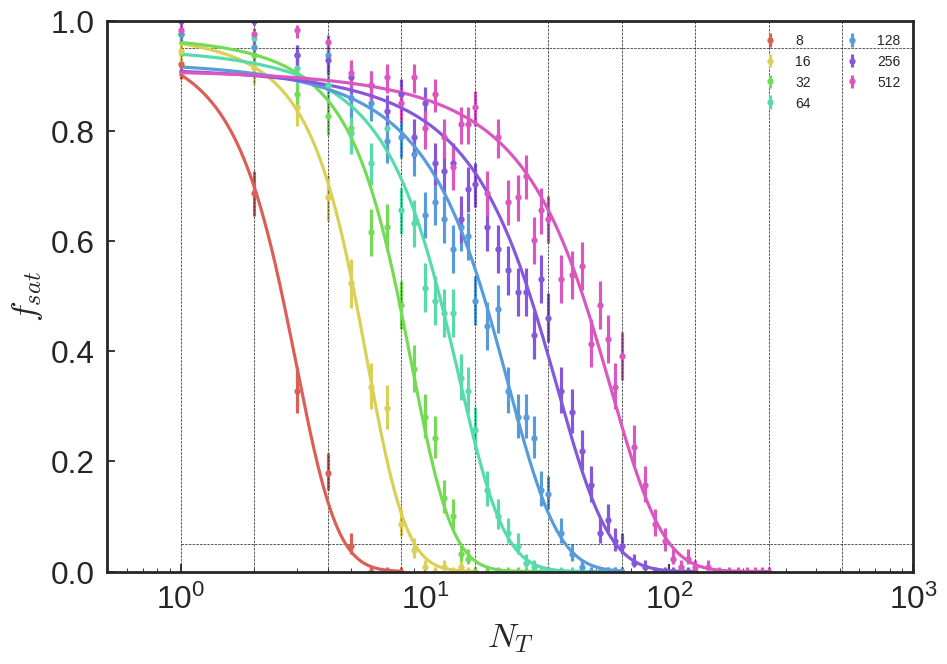

8.0
[ 13.7545828    1.87654909]
[ 0.30387328  0.44245835]
7.32972182273
10.0 18.0
16.0
[ 25.39817475   3.849698  ]
[ 0.29037976  0.12143345]
6.59744601235
18.0 33.0
32.0
[ 41.09556883  10.19156075]
[ 1.17459388  5.19835428]
4.03231358271
21.0 61.0
64.0
[ 52.14816016  10.41277565]
[ 0.79479082  0.34442673]
5.00809408828
31.0 73.0
128.0
[ 67.30589778  14.42935321]
[ 1.28001226  0.46780245]
4.66451245704
38.0 96.0
256.0
[ 83.933362    17.46452855]
[ 1.49494913  0.89584299]
4.80593345293
49.0 119.0
512.0
[ 104.42925776   20.9590712 ]
[ 2.03113015  0.98600813]
4.98253270652
63.0 146.0


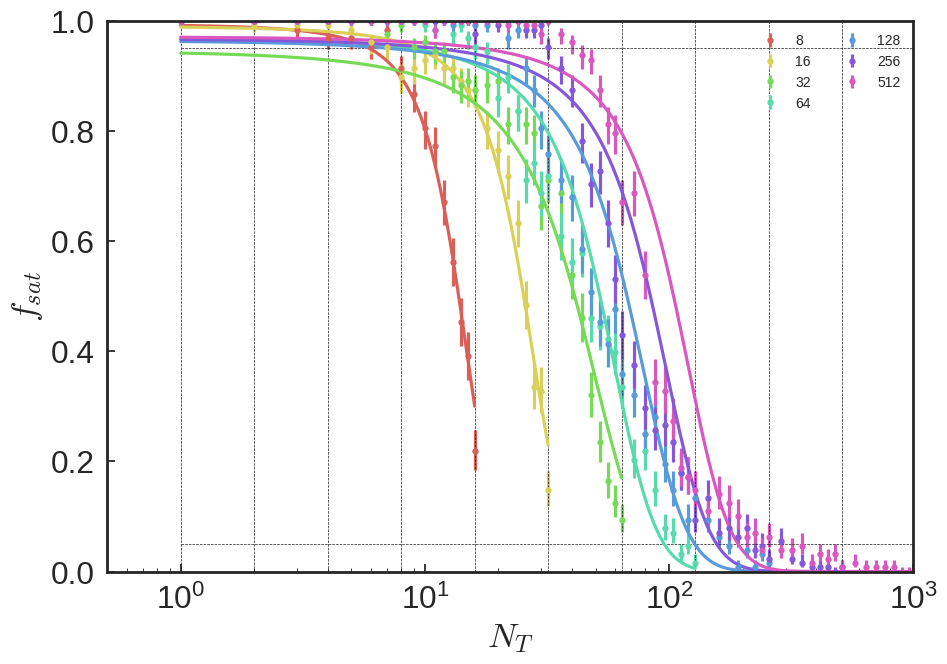

8.0
[ 12.37597241   1.5728113 ]
[ 0.15607312  0.05711696]
7.86869500088
9.0 16.0
16.0
[ 19.50089997   2.91708292]
[ 0.24150811  0.10688529]
6.68506877913
14.0 25.0
32.0
[ 27.87248318   4.37428232]
[ 0.34175966  0.13831204]
6.37189854775
19.0 37.0
64.0
[ 35.62320547   5.64409072]
[ 0.50272563  0.2029476 ]
6.31159335374
24.0 47.0
128.0
[ 48.89335868   7.90266118]
[ 0.77117907  0.44328739]
6.18694862003
33.0 65.0
256.0
[ 65.74407243   9.86132094]
[ 1.04177908  0.43999919]
6.666862665
46.0 85.0
512.0
[ 89.90282282  12.66036253]
[ 1.52089299  0.64950287]
7.10112546794
65.0 115.0


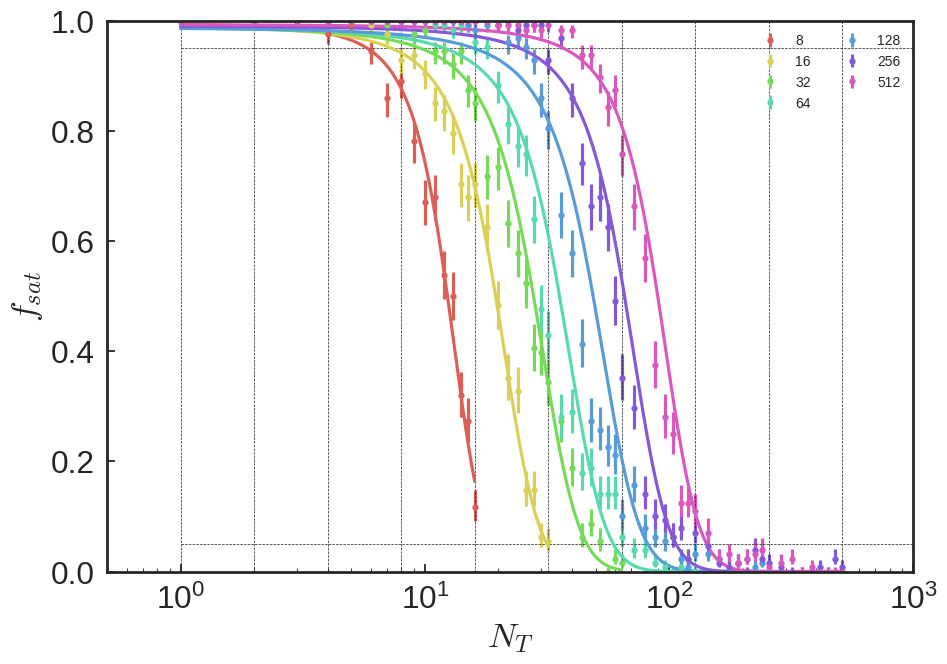

8.0
[ 3.35281214  0.561458  ]
[ 0.07776639  0.03304413]
5.97161701379
2.0 4.0
16.0
[ 4.62434482  0.78243422]
[ 0.0984653   0.03633851]
5.91020268258
3.0 6.0
32.0
[ 7.03144907  1.30719364]
[ 0.10836929  0.05092342]
5.37904166182
4.0 10.0
64.0
[ 11.31820405   2.11299089]
[ 0.18343837  0.05741353]
5.35648501928
7.0 16.0
128.0
[ 19.18892214   3.82679437]
[ 0.26611201  0.10544279]
5.01435935656
12.0 27.0
256.0
[ 31.64583414   6.51741359]
[ 0.38310063  0.1801085 ]
4.85558169553
19.0 45.0
512.0
[ 52.55482616  11.26106241]
[ 0.94973692  0.30085745]
4.66695097147
30.0 75.0


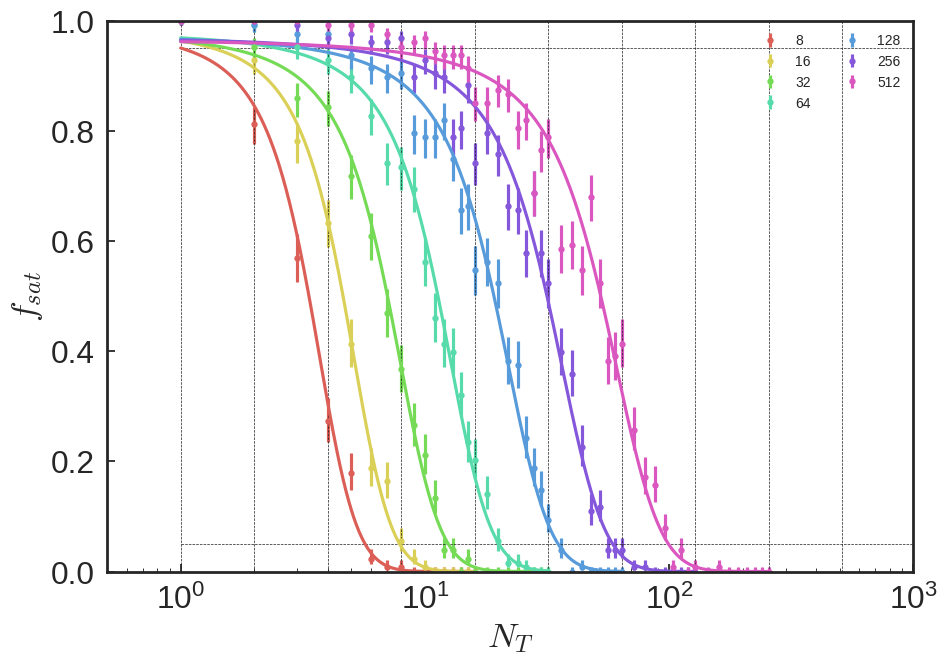

In [8]:
def binomMLE(x, y, dist_param, func, jac=None, p0=None, bounds=None):
    
    n = dist_param.astype(np.int)
    k = (n*y).astype(np.int)
        
    fit_func = lambda theta: -np.sum(k * np.log(func(x, *theta) + np.sqrt(np.finfo(float).eps)) 
                                          + (n - k) * np.log(1.0 - func(x, *theta) + np.sqrt(np.finfo(float).eps)))
    
#     fit_jac = lambda theta: np.array([-np.sum((k * 1.0/(func(x, *theta) + 1e-12) 
#                                           - (n - k) * 1.0/(1.0 - func(x, *theta) + 1e-12))* jac(x, *theta)[0]),
#                                      -np.sum((k * 1.0/(func(x, *theta) + 1e-12) 
#                                           - (n - k) * 1.0/(1.0 - func(x, *theta) + 1e-12))* jac(x, *theta)[1])])
    
    
    res = spo.minimize(fit_func, p0, jac=None,
                       method='L-BFGS-B', options={'gtol': np.sqrt(np.finfo(float).eps), 'disp': False},
                      bounds=bounds)
    
#     print res
    
    return res.x

def mcError(x, y, dist_param, fit_func, p0, fit_jac=None, dist="gaussian", bounds=None, nresample=100, plot=False):
    
    p = np.zeros([len(p0), nresample], float)
    
    x = np.array(x, float)
    y = np.array(y, float)
    dist_param = np.array(dist_param, float)
        
    for n in range(nresample):
#         if n % 100 == 0:
#             print n

        y_tmp = np.array(rand.binomial(dist_param.astype(int), y) / dist_param)

        avg =  binomMLE(x, y_tmp, dist_param, fit_func, jac=fit_jac, p0=p0, bounds=bounds)
        
        p[:, n] = avg
    
    if plot:
    
        fig, axes = plt.subplots(1, len(p0), figsize=(24, 8))
        for i in range(len(p0)):
            sns.distplot(p[i], ax=axes[i], rug=True, rug_kws={"color": "g"},
                         kde_kws={"color": "k", "lw": 3},
                         hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})
    
    return np.mean(p, axis=1), np.std(p, axis=1), sp.stats.skew(p, axis=1)



func = lambda x, mu, sigma : sp.special.expit(-(x-mu) / sigma / np.sqrt(2))
# jac = lambda x, mu, sigma : np.array([1.0/np.sqrt(np.pi * sigma**2) * np.exp((x-mu)**2 / sigma**2),
#                             (x-mu)/np.sqrt(np.pi * sigma**2) * np.exp((x-mu)**2 / sigma**2)])


# func = lambda x, mu, sigma : 1 / (((x-1)/sigma)**mu + 1.0)
# jac = lambda x, mu, sigma : - mu (x/sigma)**mu / x / ((x/sigma)**mu + 1)**2

         
df_fsat = pd.DataFrame(columns=['NN', 'Lp', 'eta', 'NE', 'NTc', 'NTc_err', 'width', 'width_err'], dtype=float)

for (Lp ,eta), group0 in df_agg.groupby(['Lp', 'eta']):
    
    palette = it.cycle(sns.color_palette("hls", len(group0.groupby('NN'))))

    fig, ax1 = plt.subplots()

    for NN, group1 in group0.groupby('NN'):

        color = next(palette)

        NT = np.array(group1['NTS'])
        count = np.array(group1['count'])

        fsat = np.array(group1['fsat'])

        fsat_low = np.array(group1['fsat_err_low'])
        fsat_up = np.array(group1['fsat_err_up'])

        NE = np.mean(group1['NE'])


        ax1.errorbar(NT, fsat, 
                    yerr=[fsat_low, fsat_up], fmt=".", label="{:}".format(int(NN)), 
                     color=color)




        avg, std, skew = mcError(NT, fsat, count, func, [15.0, 10.0],
                                 dist="binomial", bounds=[(1, 300), (1e-2, 100)], plot=False, nresample=32)


#         spl = spi.UnivariateSpline(NT, fsat, s=0, ext=0)

#         xs = np.arange(np.min(NT), np.max(NT), 0.1)
#         ax1.plot(xs, spl(xs), color=color)
    
#         rfunc = lambda x: 0.5 - spl(x)
#         x0 = spo.brentq(rfunc, avg[0]-avg[1], avg[0]+avg[1])
        
#         print x0, avg[0]
#         avg[0] = x0
    
        print NN
        print avg
        print std
#         print skew

        print avg[0] / avg[1]

        sigma = 2
        print np.round(avg[0]-sigma*avg[1]), np.round(avg[0]+sigma*avg[1])

        ax1.plot(np.linspace(np.min(NT), np.max(NT), 1000), func(np.linspace(np.min(NT), np.max(NT), 1000), *avg), color=color)
        
    
        
    
        row = pd.Series({'NN': NN, 'Lp': Lp, 'eta': eta, 'NE': NE, 'NTc': avg[0], 'NTc_err': std[0], 
                         'width': avg[1], 'width_err': std[1]})
        
        
        df_fsat = df_fsat.append(row, ignore_index=True)


    for i in range(0, 11):
        ax1.vlines(2**i, 0, 1.0, color='k', linestyle='dashed', linewidth=0.5)


    ax1.hlines([0.05, 0.95], 1e0, 1e3, color='k', linestyle='dashed', linewidth=0.5)
        
    ax1.legend(loc="upper right", ncol=2, prop={'size':10})
    ax1.set_xlabel(r'$N_T$')
    ax1.set_ylabel(r'$f_{sat}$')
    ax1.set_xlim(0.5e0, 1e3)
    ax1.set_xscale('log')
    ax1.set_ylim(0,1)
    
#     ax1.set_title(r'$\log(p)={0:.1f}, \Delta={1:.1E}$'.format(Lp, eta))

    # plt.savefig("prob_success_err.png")
    # plt.savefig("fsat_slice_2D.eps")

    plt.show()
    


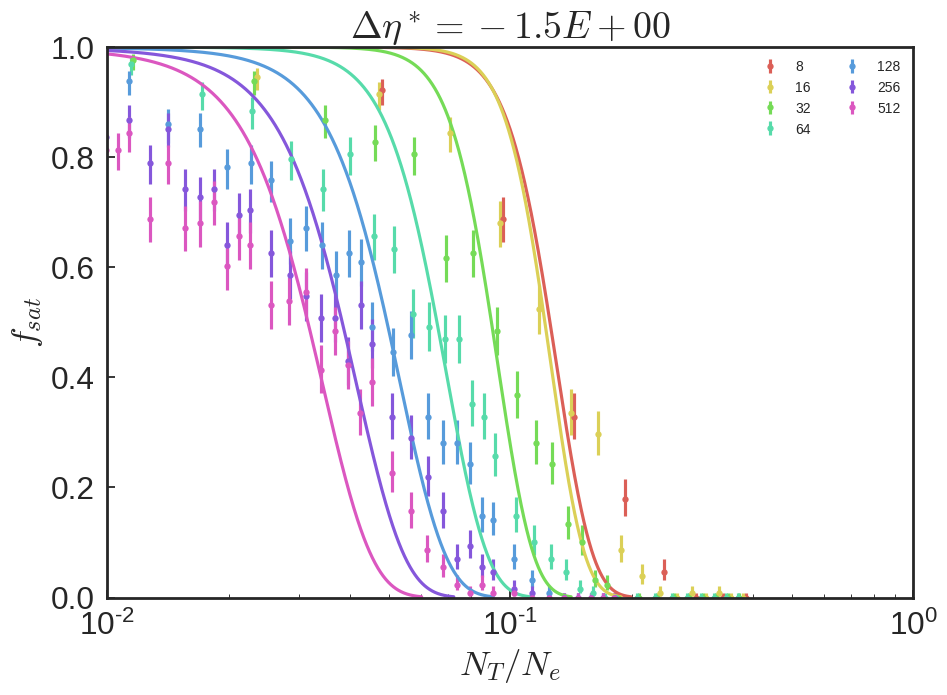

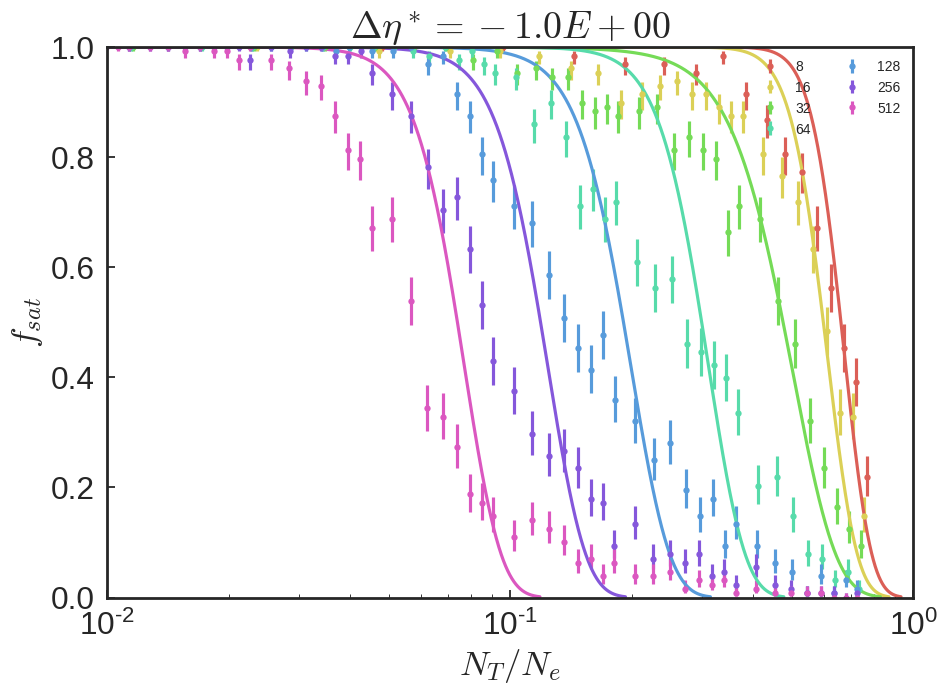

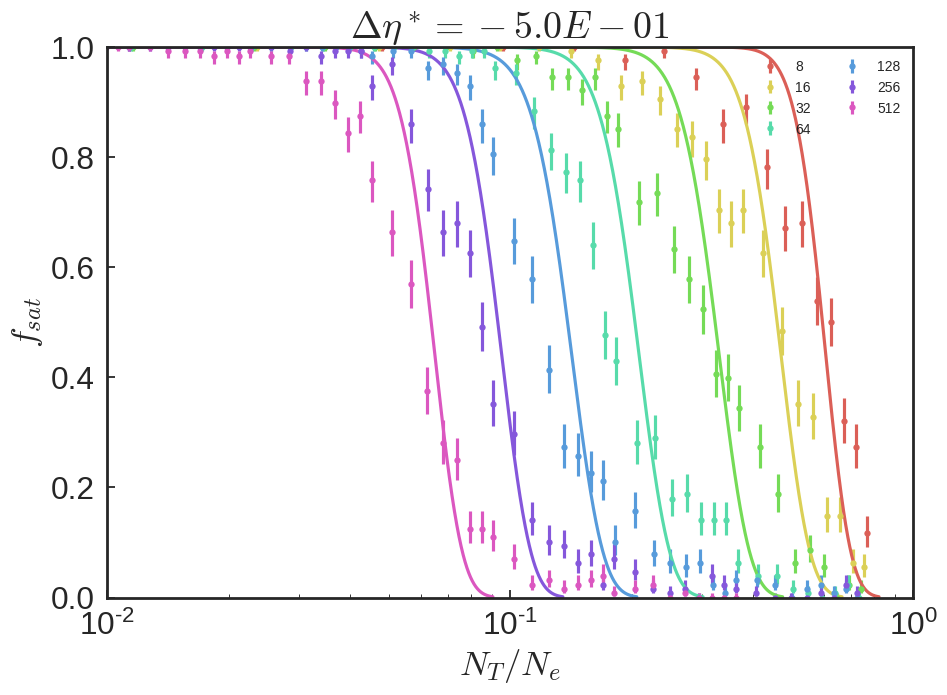

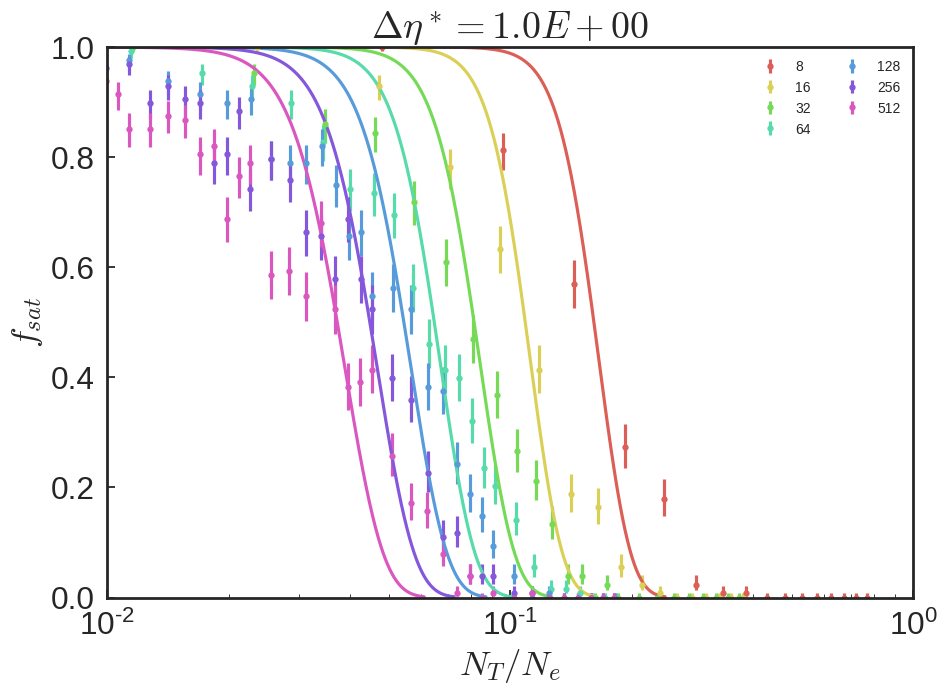

In [9]:
func = lambda x, mu, sigma : 0.5*sp.special.erfc((x-mu) / sigma / np.sqrt(2))

for (Lp ,eta), group0 in df_agg.groupby(['Lp', 'eta']):

    palette = it.cycle(sns.color_palette("hls", len(group0.groupby('NN'))))

    fig, ax1 = plt.subplots()
    
    for NN, group1 in group0.groupby('NN'):

        color = next(palette)

        NT = np.array(group1['NTS'])

        fsat = np.array(group1['fsat'])

        NE = np.mean(group1['NE'])

        ax1.errorbar(NT / NE, fsat, 
                    yerr=[group1['fsat_err_low'], group1['fsat_err_up']], fmt=".", label="{:}".format(int(NN)), 
                     color=color)

        NTc = np.array(df_fsat[(df_fsat.eta==eta) & (df_fsat.Lp==Lp) & (df_fsat.NN==NN)]['NTc'])[0]
        width = np.array(df_fsat[(df_fsat.eta==eta) & (df_fsat.Lp==Lp) & (df_fsat.NN==NN)]['width'])[0]
                
        x = np.linspace(0, NTc+3*width, 1000)
                        
        ax1.plot(x / NE, func(x, NTc, width), color=color)



    ax1.legend(loc="upper right", ncol=2, prop={'size':10})
    ax1.set_xlabel(r'$N_T / N_e$')
    ax1.set_ylabel(r'$f_{sat}$')
    ax1.set_xlim(1e-2, 1e0)
    ax1.set_ylim(0,1)
    ax1.set_xscale('log')
    ax1.set_title(r'$\Delta\eta^*={:.1E}$'.format(eta))

    # plt.savefig("prob_success_err.png")
    # plt.savefig("fsat_slice_2D.eps")

    plt.show()

[ 16.  32.  64.]
[  16.   32.   64.  128.]
[  16.   32.   64.  128.  256.]
[  16.   32.   64.  128.  256.  512.]
0.1
[ 0.73169797  0.74031921]


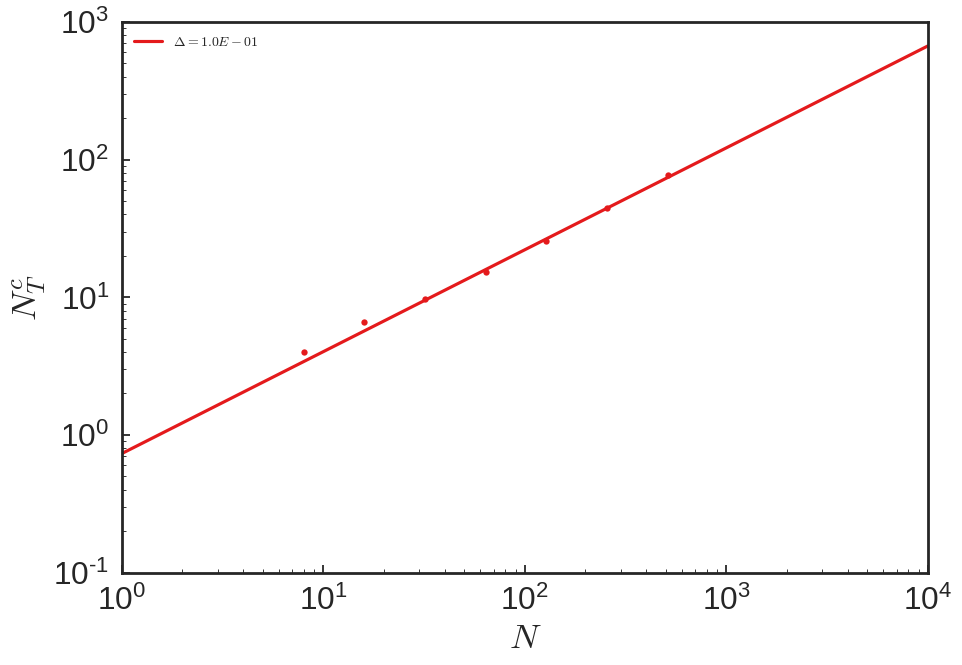

0.1
[ 0.73169797  0.74031921]


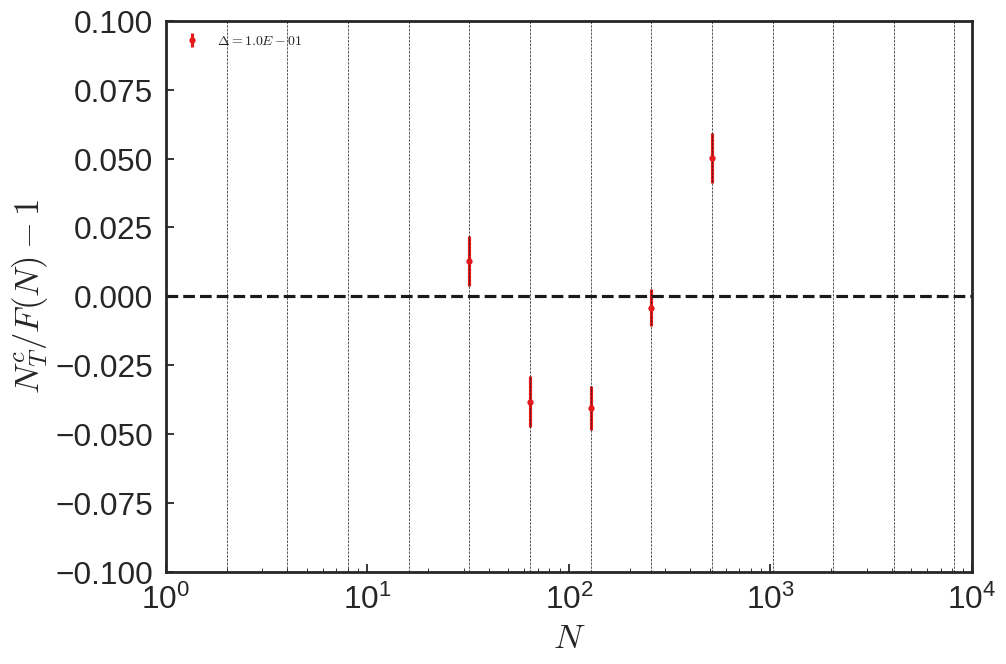

In [10]:
def func1(x, B, C):
    return B * x**C

def func3(x, A, B, C):
    return A + B * x**C

def func2(x, A, B, C):
        
    return B * x**C * (1 + np.log(x)**A)


start = 1
stop = len(df_fsat.groupby(['NN']))

df_scale = pd.DataFrame(columns=['eta', 'start', 'stop', 'NTc_offset', 'NTc_coeff', 'NTc_exp', 
                                 'NTc_offset_err', 'NTc_coeff_err', 'NTc_exp_err', 'width_exp', 'width_exp_err'], dtype=float)


for n in range(start+3, stop+1):

    for eta, group in df_fsat.groupby(['eta']):
        
        NN = np.array(group['NN'])

        NTc = np.array(group['NTc'])
        NTc_err = np.array(group['NTc_err'])
        
        print NN[start:n]
                        
        avg, std = spo.curve_fit(func1, NN[start:n], NTc[start:n], 
                                 p0=[0, 1], 
                                 sigma=NTc_err[start:n], 
                                 absolute_sigma=True, maxfev=10000, 
                                 bounds=([-np.inf, -np.inf], [np.inf, np.inf]))


        row = pd.Series({'eta': eta, 'start': start, 'stop': n, 'NTc_offset':0.0, 
                         'NTc_coeff':avg[0], 'NTc_exp': avg[1], 
                         'NTc_offset_err':0.0, 
                         'NTc_coeff_err':np.sqrt(std[0][0]), 
                         'NTc_exp_err': np.sqrt(std[1][1])})

        df_scale = df_scale.append(row, ignore_index=True)


        
fig, ax1 = plt.subplots(1,1)

palette = it.cycle(sns.color_palette("Set1", 4))


for eta, group in df_fsat.groupby(['eta']):
    
    color = next(palette)
    
    NN = np.array(group['NN'])

    NTc = np.array(group['NTc'])
    NTc_err = np.array(group['NTc_err'])
    
    avg = np.zeros(2, float)
    
#     avg[0] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_offset']
    avg[0] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_coeff']
    avg[1] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_exp']
    
    print eta
    print avg
    
    ax1.plot(10**np.linspace(0, 4, 100), func1(10**np.linspace(0,4, 100), *avg), '-', color=color,
            label=r'$\Delta={0:.1E}$'.format(eta))
    ax1.errorbar(NN, NTc, yerr=NTc_err, fmt=".", color=color)
    


ax1.set_xlim(1e0, 1e4)
ax1.set_ylim(1e-1, 1e3)

ax1.set_xlabel("$N$")
ax1.set_ylabel(r"$N_T^c$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc="upper left", prop={'size':10})


plt.show()


fig, ax1 = plt.subplots(1,1)

palette = it.cycle(sns.color_palette("Set1", 4))


for eta, group in df_fsat.groupby(['eta']):
    
    color = next(palette)
    
    NN = np.array(group['NN'])

    NTc = np.array(group['NTc'])
    NTc_err = np.array(group['NTc_err'])
    
    avg = np.zeros(2, float)
    
#     avg[0] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_offset']
    avg[0] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_coeff']
    avg[1] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_exp']
    
    print eta
    print avg

    ax1.errorbar(NN, NTc / func1(NN, *avg) - 1.0, yerr=NTc_err / func1(NN, *avg), fmt=".", color=color,
            label=r'$\Delta={0:.1E}$'.format(eta))
    
for i in range(0, 14):
        ax1.vlines(2**i, -0.1, 0.1, color='k', linestyle='dashed', linewidth=0.5)
    
ax1.set_xlim(1e0, 1e4)
ax1.set_ylim(-0.1, 0.1)

ax1.hlines(0, xmin=1e0, xmax=1e4, linestyle='dashed', color='k')

ax1.set_xlabel("$N$")
ax1.set_ylabel(r"$N_T^c / F(N) - 1$")
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.legend(loc="upper left", prop={'size':10})


plt.show()

                     # # fig, ax2 = plt.subplots(1,1)

# palette = it.cycle(sns.color_palette("Set1", 4))


# for (Lp, eta) in sorted(NN_list):
    
#     color = next(palette)
    
#     print (Lp, eta)
    
#     # avg, std, skew = mcError(NN_list[0:], width_list[0:], np.array(width_err_list[0:]), func1, [0.5, 0.5], 
#     #                    bounds=([-10, -10],[10, 10]),
#     #                    nresample=1000, plot=False)0

#     avg, std = spo.curve_fit(func2, NN_list[(Lp, eta)][start:stop], w_list[(Lp, eta)][start:stop], 
#                              p0=[10.0, 10, 1.0], 
#                              sigma=np.array(w_err_list[(Lp, eta)][start:stop]), 
#                              absolute_sigma=True, maxfev=10000)

#     print avg
#     print std

#     ax2.plot(10**np.linspace(0, 4, 100), func2(10**np.linspace(0, 4, 100), *avg), '-', color=color, 
#             label=r'$\log(p)={0:.1f}, \Delta\eta^*={1:.1E}$'.format(Lp, eta))


#     ax2.errorbar(NN_list[(Lp, eta)], w_list[(Lp, eta)], yerr=np.array(w_err_list[(Lp, eta)]), fmt=".", color=color)

# # handles, labels = ax2.get_legend_handles_labels()

# # line = mlines.Line2D([], [], lw=0.0)
# # handles.append(line)
# # labels.append(r"$\beta = {0:.2f}$".format(avg[1]))
# # # labels.append(r"$\beta = {0:.3f} \pm {1:.3f}$".format(avg[1], std[1]))

# # ax2.legend(handles, labels, loc="lower right")

# ax2.set_xlabel("$N$")
# ax2.set_ylabel(r"$\sigma_{T}$")
# ax2.set_xscale('log')
# ax2.set_yscale('log')
# ax2.legend(loc="upper left", prop={'size':10})

# ax2.set_xlim(1e0, 1e4)
# ax2.set_ylim(1e-1, 1e2)

# # plt.savefig("transition_width_2D.eps")

# plt.show()

[   8.   12.   16.   24.   32.   48.   64.   96.  128.  192.  256.  384.
  512.  768.]
[    8.    12.    16.    24.    32.    48.    64.    96.   128.   192.
   256.   384.   512.   768.  1024.]
   eta  start  stop  NTc_offset  NTc_coeff   NTc_exp  log_coeff   log_exp  \
0  0.1    0.0  14.0    0.997683   0.549478  0.827114  -0.012042  0.474763   
1  0.1    0.0  15.0    1.062217   0.558763  0.867903  -0.084971  0.254485   

   NTc_offset_err  NTc_coeff_err  NTc_exp_err  log_coeff_err  log_exp_err  
0        0.261176       0.075022     0.086366       0.059273     0.571862  
1        0.260480       0.192187     0.171685       0.502327     0.628446  


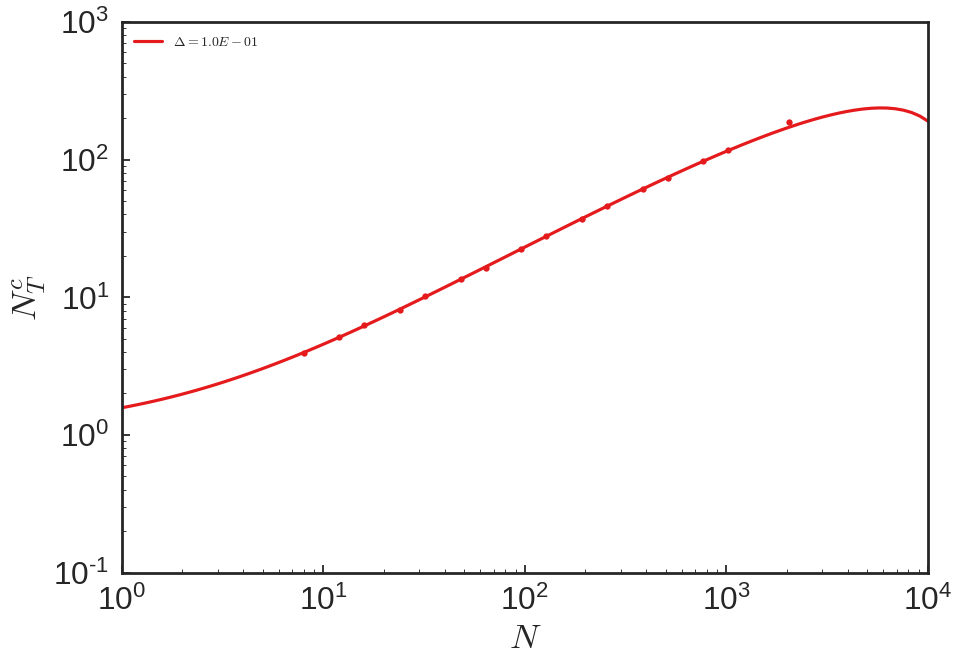

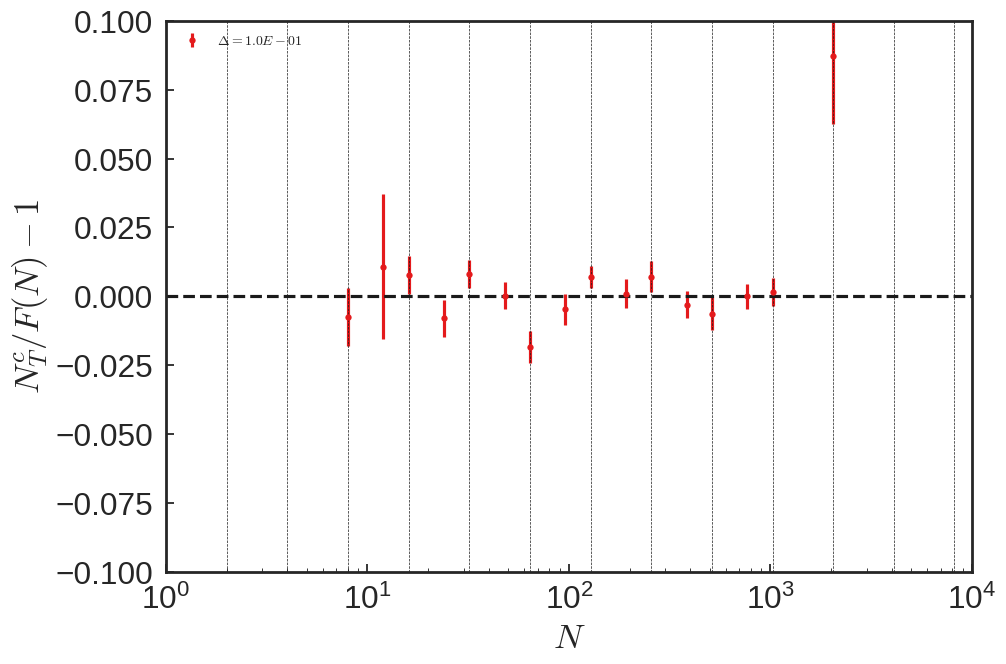

In [9]:
# def func(x, A, B, C, D, E):
        
#     return A * x**B * (1 + C*np.log(x)**D) + E

def func(x, A, B, C, D, E):
        
    return A * x**B * (1 + C*x**D) + E


start = 0
stop = len(df_fsat.groupby(['NN']))-1

df_scale = pd.DataFrame(columns=['eta', 'start', 'stop', 'NTc_offset', 'NTc_coeff', 'NTc_exp', 
                                 'log_coeff', 'log_exp',
                                 'NTc_offset_err', 'NTc_coeff_err', 'NTc_exp_err', 
                                 'log_coeff_err', 'log_exp_err'], dtype=float)


for n in range(start+stop-1, stop+1):

    for eta, group in df_fsat.groupby(['eta']):
        
        NN = np.array(group['NN'])

        NTc = np.array(group['NTc'])
        NTc_err = np.array(group['NTc_err'])
        
        print NN[start:n]
                        
        avg, std = spo.curve_fit(func, NN[start:n], NTc[start:n], 
                                 p0=[1.0, 1.0, 0.2, 1.0, 1.0], 
                                 sigma=NTc_err[start:n], 
                                 absolute_sigma=True, maxfev=100000000, 
                                 bounds=([-40, 0, -10, -1.0, -5.0], 
                                         [40, 2, 10, 5.0, 5.0]))


        row = pd.Series({'eta': eta, 'start': start, 'stop': n, 'NTc_offset':avg[4], 
                         'NTc_coeff':avg[0], 'NTc_exp': avg[1], 
                         'log_coeff':avg[2], 'log_exp': avg[3],
                         'NTc_offset_err':np.sqrt(std[4][4]), 
                         'NTc_coeff_err':np.sqrt(std[0][0]), 
                         'NTc_exp_err': np.sqrt(std[1][1]),
                         'log_coeff_err':np.sqrt(std[2][2]), 
                         'log_exp_err': np.sqrt(std[3][3])})

        df_scale = df_scale.append(row, ignore_index=True)


print df_scale
        
        
fig, ax1 = plt.subplots(1,1)

palette = it.cycle(sns.color_palette("Set1", 4))


for eta, group in df_fsat.groupby(['eta']):
    
    color = next(palette)
    
    NN = np.array(group['NN'])

    NTc = np.array(group['NTc'])
    NTc_err = np.array(group['NTc_err'])
    
    avg = np.zeros(5, float)
    
    avg[4] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_offset']
    avg[0] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_coeff']
    avg[1] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_exp']
    avg[2] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['log_coeff']
    avg[3] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['log_exp']
    
#     print eta
#     print avg
    
    ax1.plot(10**np.linspace(0, 4, 100), func(10**np.linspace(0,4, 100), *avg), '-', color=color,
            label=r'$\Delta={0:.1E}$'.format(eta))
    ax1.errorbar(NN, NTc, yerr=NTc_err, fmt=".", color=color)
    
2

ax1.set_xlim(1e0, 1e4)
ax1.set_ylim(1e-1, 1e3)

ax1.set_xlabel("$N$")
ax1.set_ylabel(r"$N_T^c$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc="upper left", prop={'size':10})


plt.show()


fig, ax1 = plt.subplots(1,1)

palette = it.cycle(sns.color_palette("Set1", 4))


for eta, group in df_fsat.groupby(['eta']):
    
    color = next(palette)
    
    NN = np.array(group['NN'])

    NTc = np.array(group['NTc'])
    NTc_err = np.array(group['NTc_err'])
    
    avg = np.zeros(5, float)
    
    avg[4] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_offset']
    avg[0] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_coeff']
    avg[1] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['NTc_exp']
    avg[2] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['log_coeff']
    avg[3] = df_scale[(df_scale.eta==eta) & (df_scale.stop==stop)]['log_exp']
    
#     print eta
#     print avg

    ax1.errorbar(NN, NTc / func(NN, *avg) - 1.0, yerr=NTc_err / func(NN, *avg), fmt=".", color=color,
            label=r'$\Delta={0:.1E}$'.format(eta))
    
for i in range(0, 14):
        ax1.vlines(2**i, -0.1, 0.1, color='k', linestyle='dashed', linewidth=0.5)
    
ax1.set_xlim(1e0, 1e4)
ax1.set_ylim(-0.1, 0.1)

ax1.hlines(0, xmin=1e0, xmax=1e4, linestyle='dashed', color='k')

ax1.set_xlabel("$N$")
ax1.set_ylabel(r"$N_T^c / F(N) - 1$")
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.legend(loc="upper left", prop={'size':10})


plt.show()

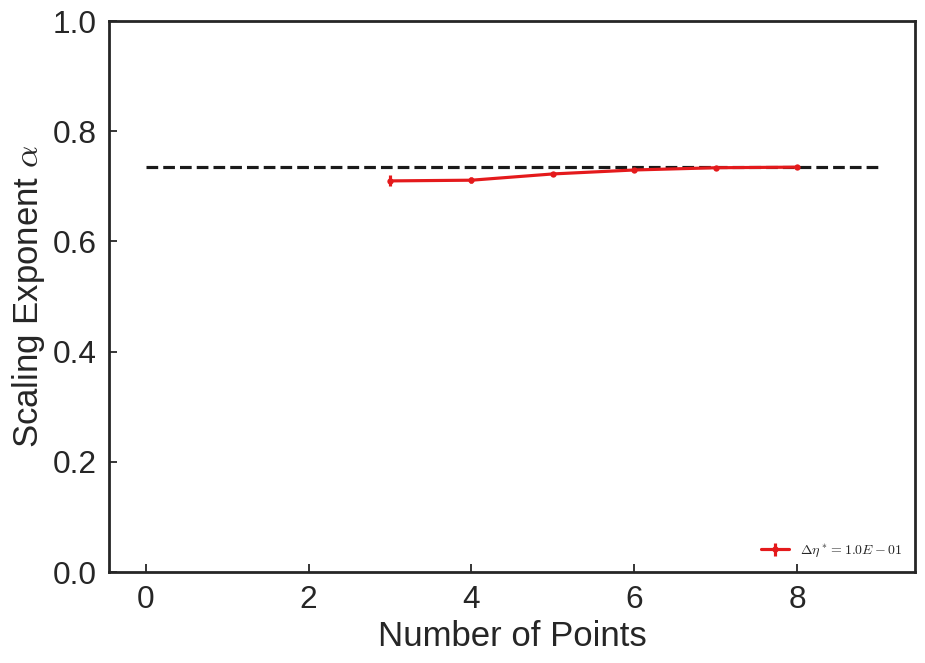

In [8]:
fig, ax1 = plt.subplots(1,1)

palette = it.cycle(sns.color_palette("Set1", 4))


for eta, group in df_scale.groupby(['eta']):
    
    color = next(palette)
    
    n = np.array(group['stop']) - np.array(group['start'])
    NTc_exp = np.array(group['NTc_exp'])
    NTc_exp_err = np.array(group['NTc_exp_err'])
    
    ax1.hlines(NTc_exp[-1], 0, stop+1 - start, linestyle='dashed', color='k')
    
    ax1.errorbar(n, NTc_exp, yerr=NTc_exp_err, fmt=".-", color=color,
            label=r'$\Delta\eta^*={0:.1E}$'.format(eta))
    
    ax1.legend(loc="lower right", prop={'size':10})

    
    

ax1.set_ylim(0, 1.0)
ax1.set_ylabel(r'Scaling Exponent $\alpha$')
ax1.set_xlabel(r'Number of Points')
plt.show()

16     0.01
17     0.10
18     1.00
19    10.00
Name: eta, dtype: float64


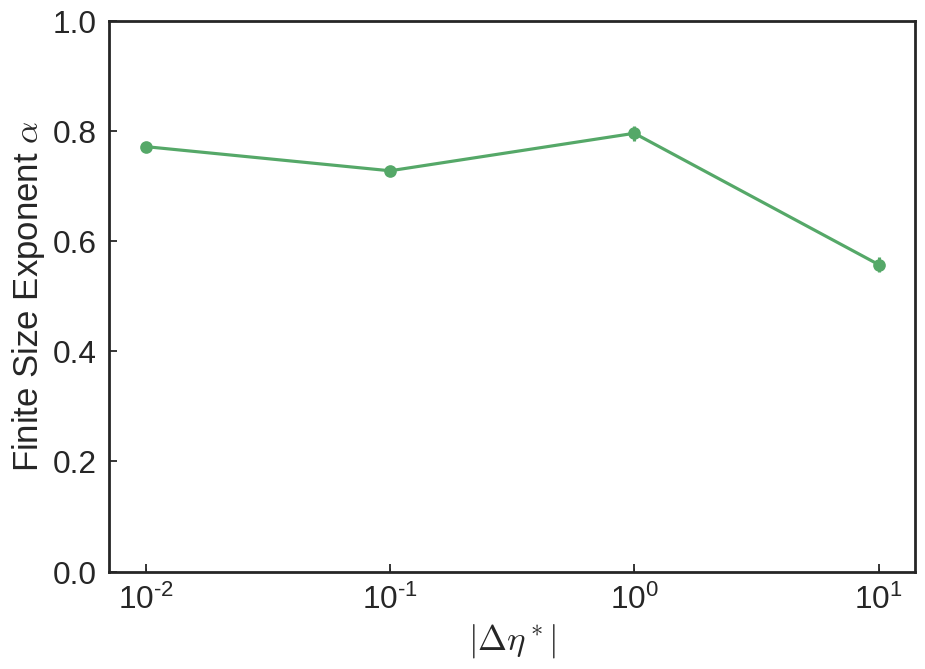

In [9]:
fig, ax1 = plt.subplots()

print df_scale[df_scale.stop==stop-1]['eta']

ax1.errorbar(df_scale[df_scale.stop==stop-1]['eta'], df_scale[df_scale.stop==stop-1]['NTc_exp'], 
             yerr=df_scale[df_scale.stop==stop-1]['NTc_exp_err'],fmt='go-')

ax1.set_ylabel(r'Finite Size Exponent $\alpha$')
ax1.set_xlabel(r'$|\Delta \eta^*|$')

ax1.set_ylim(0, 1.0)
ax1.set_xscale('symlog', linthreshx=1e-3)

plt.show()


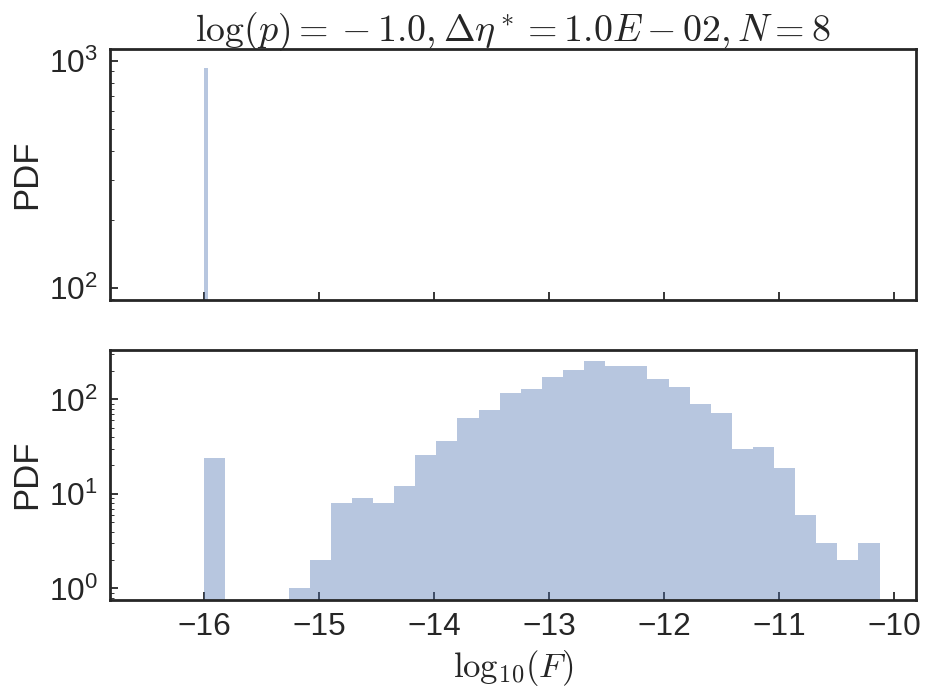

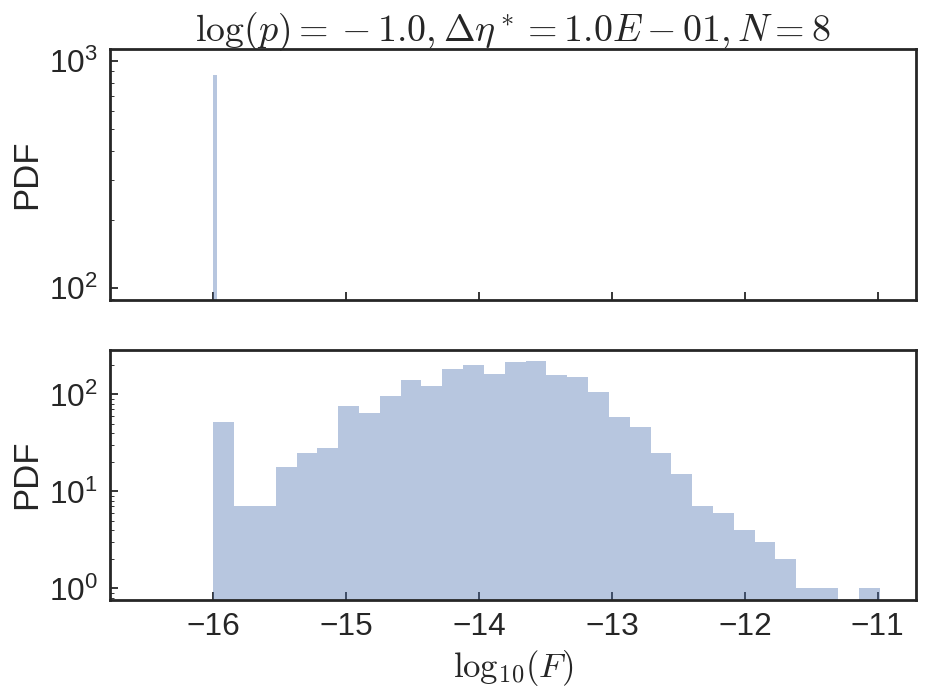

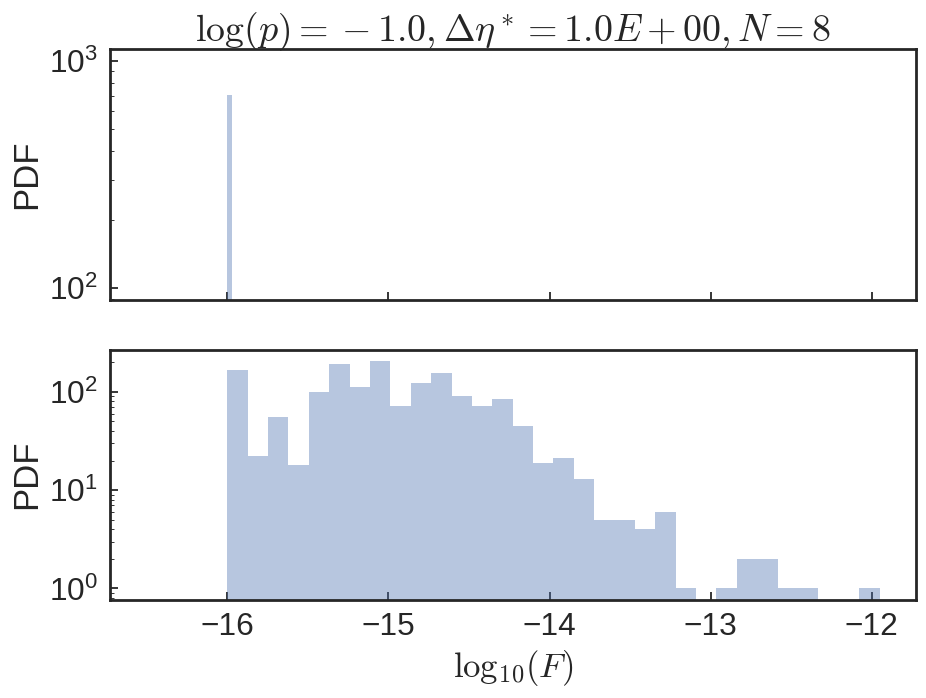

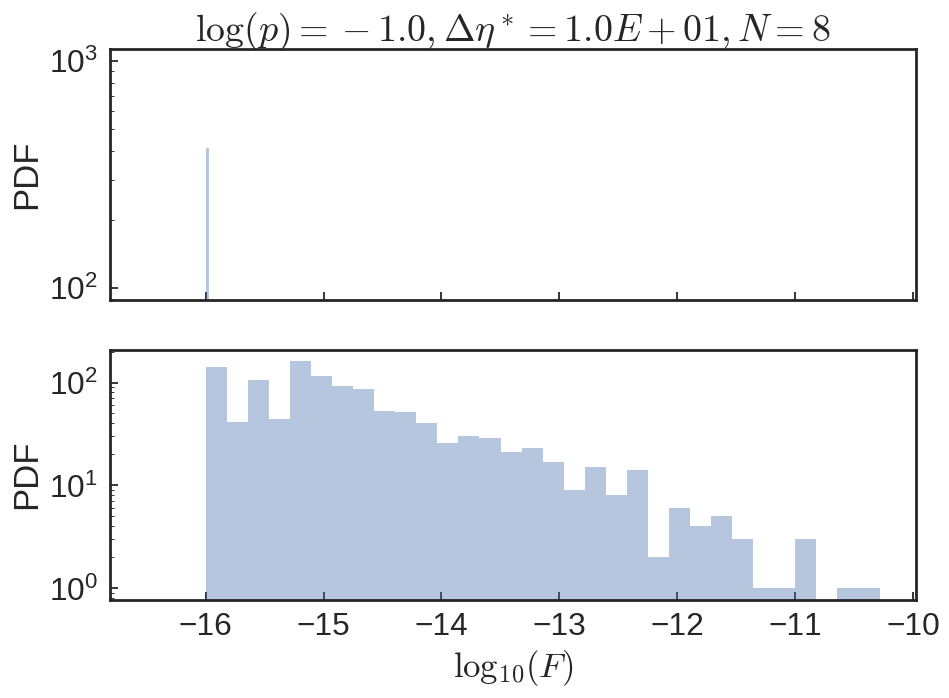

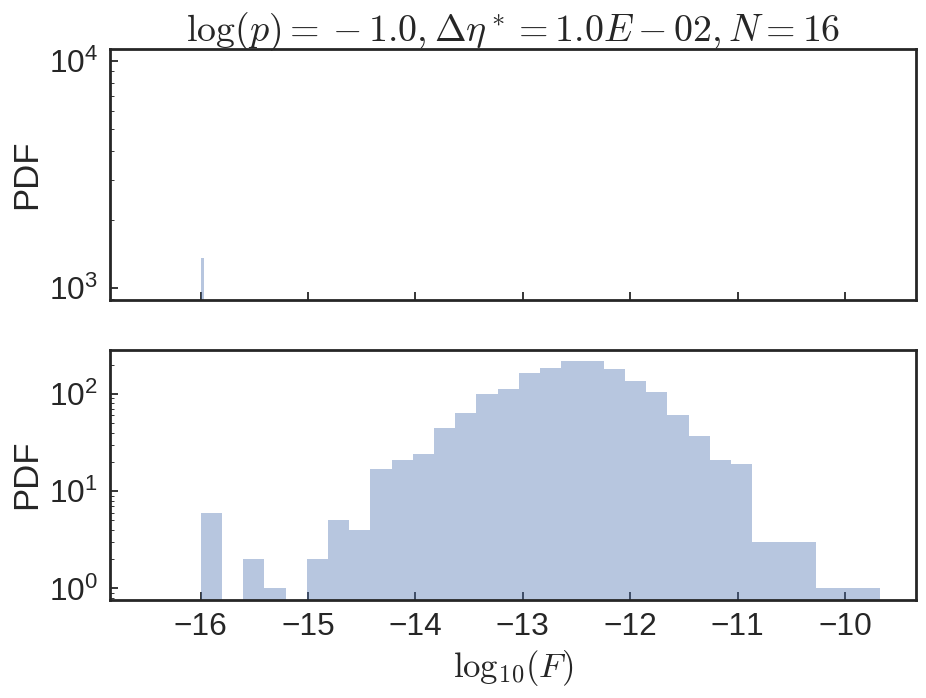

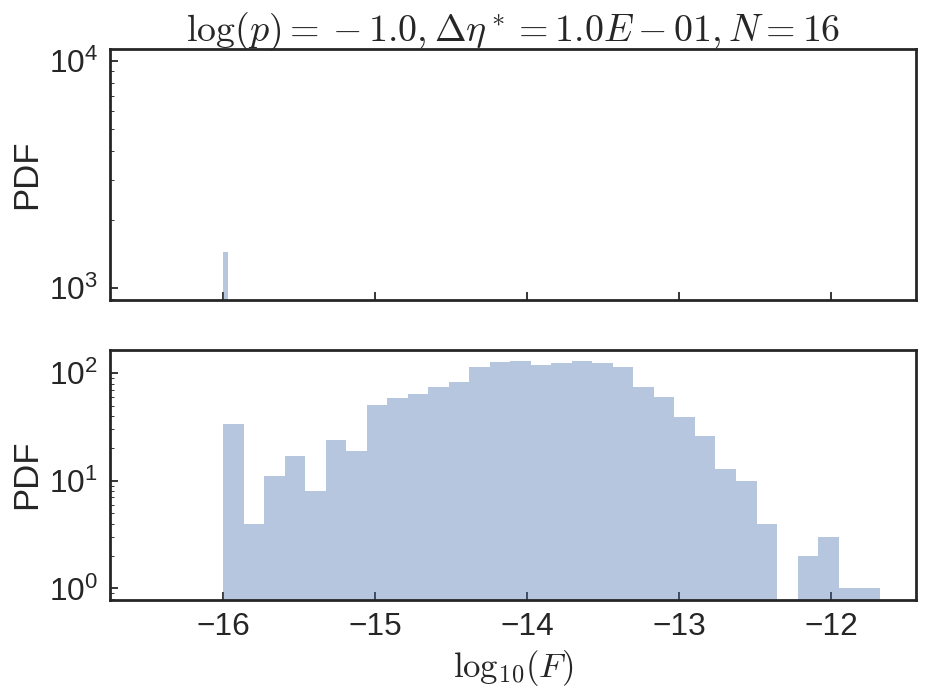

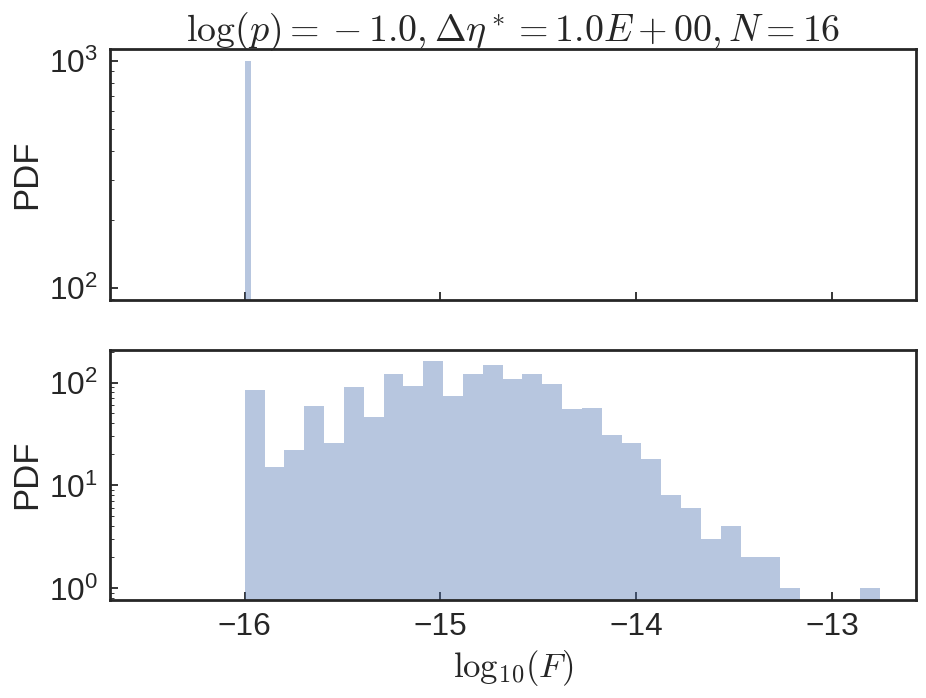

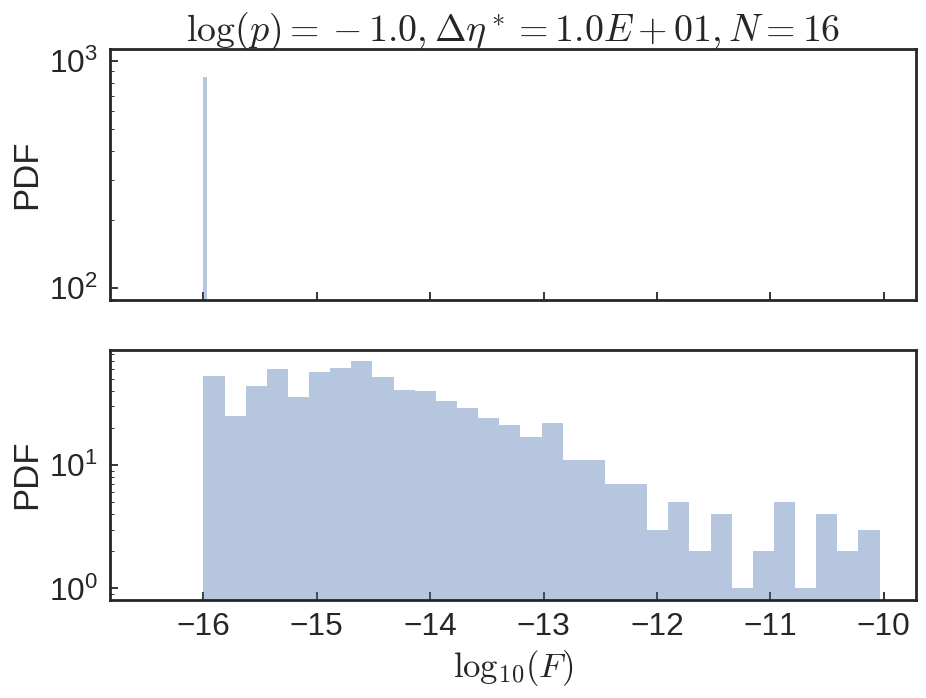

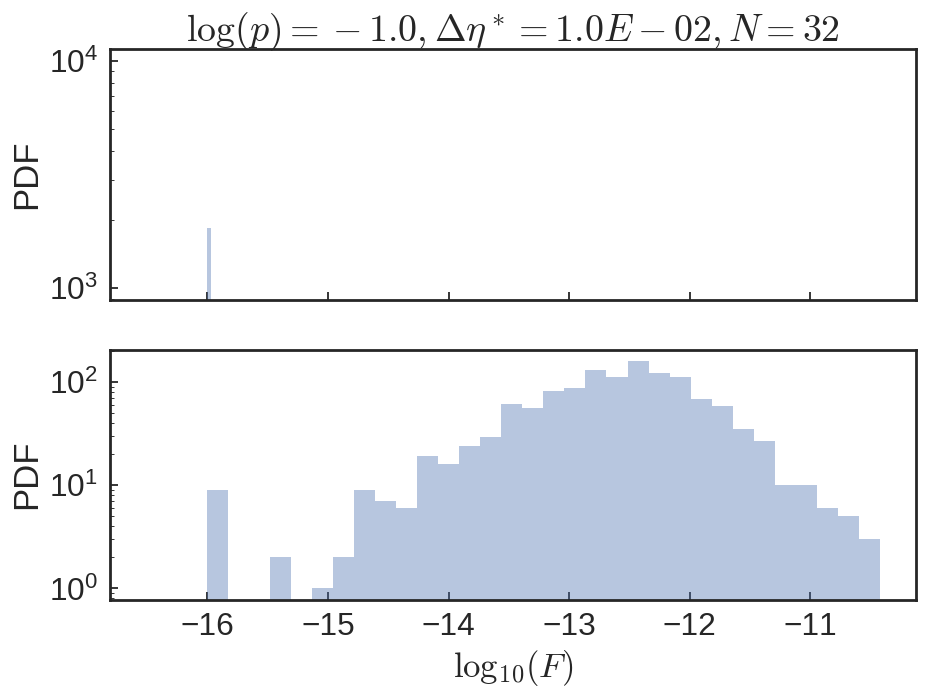

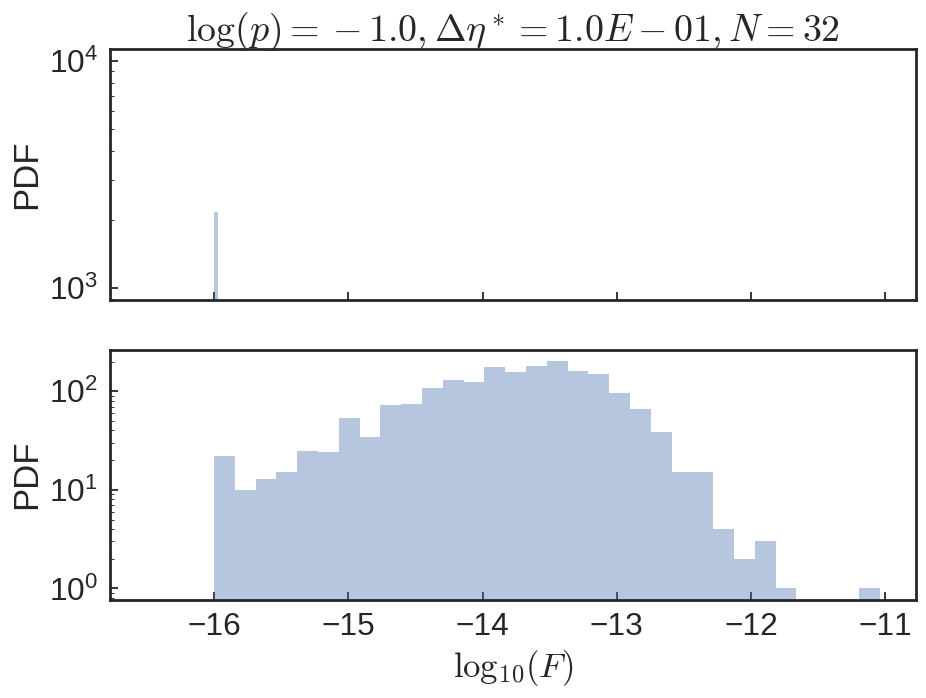

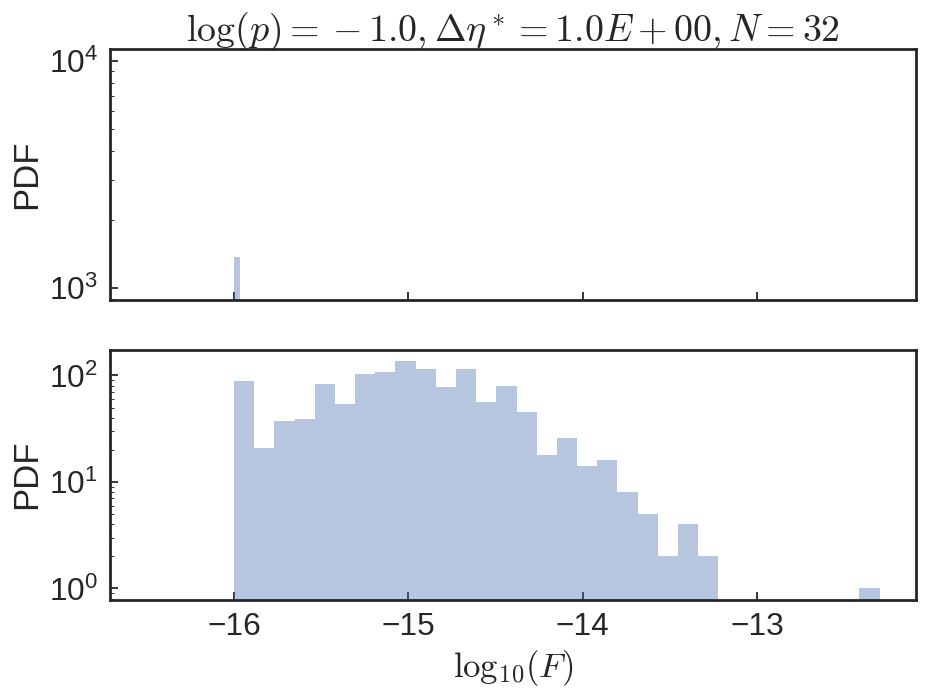

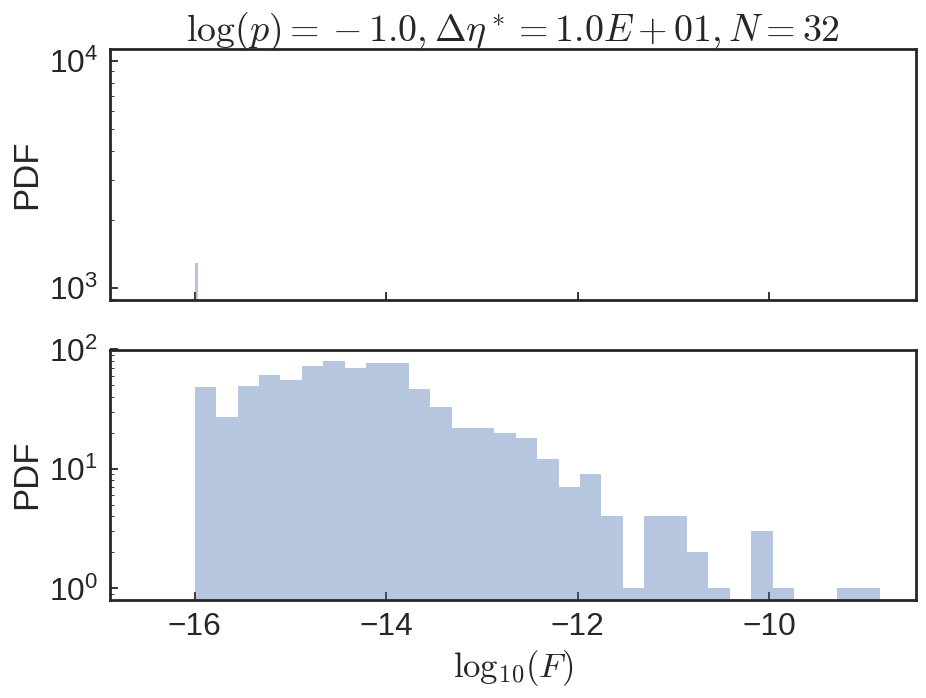

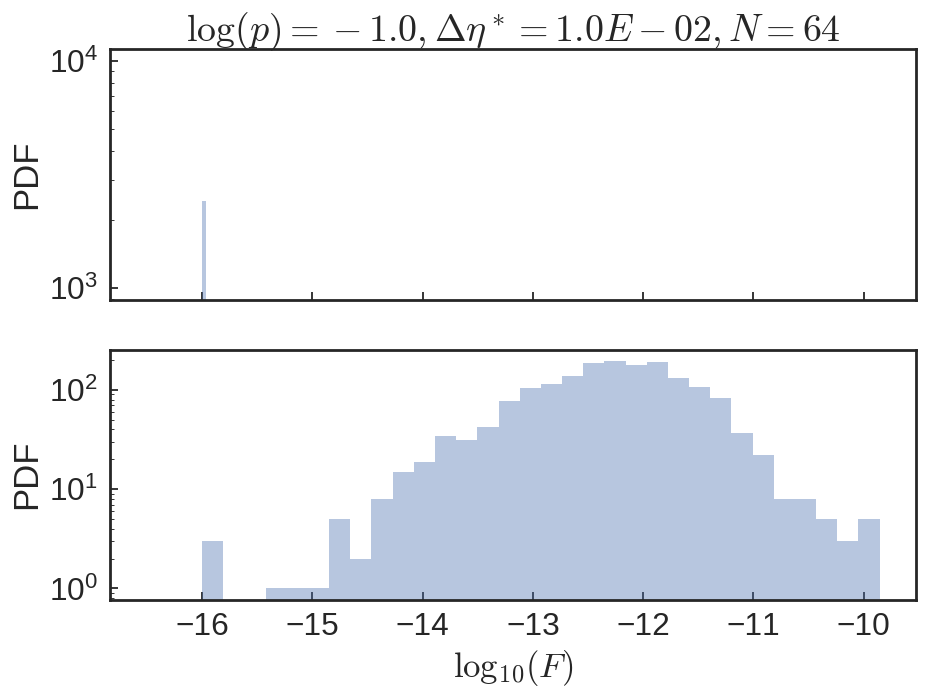

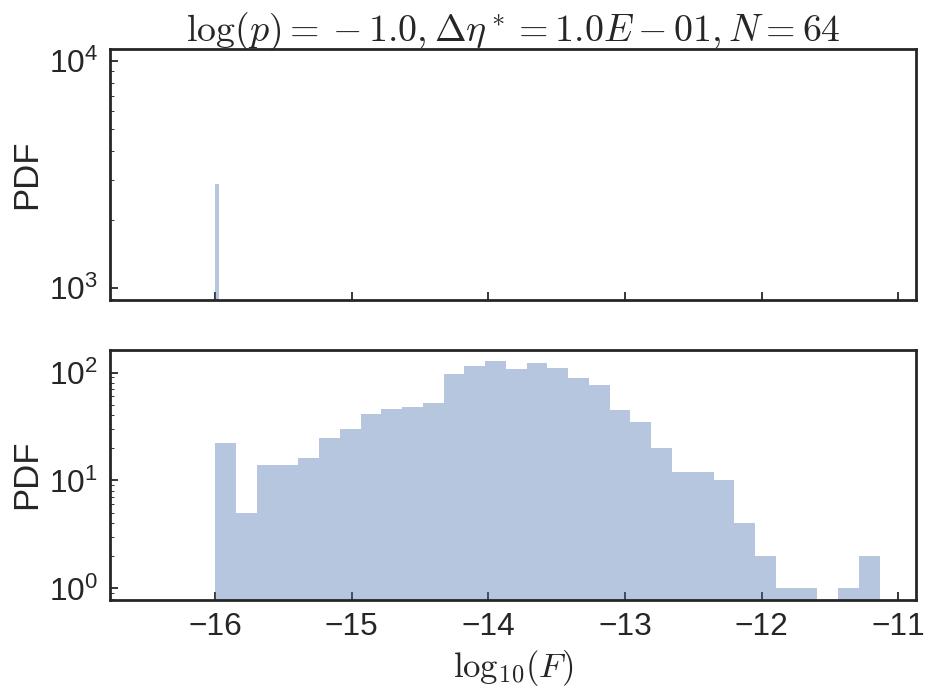

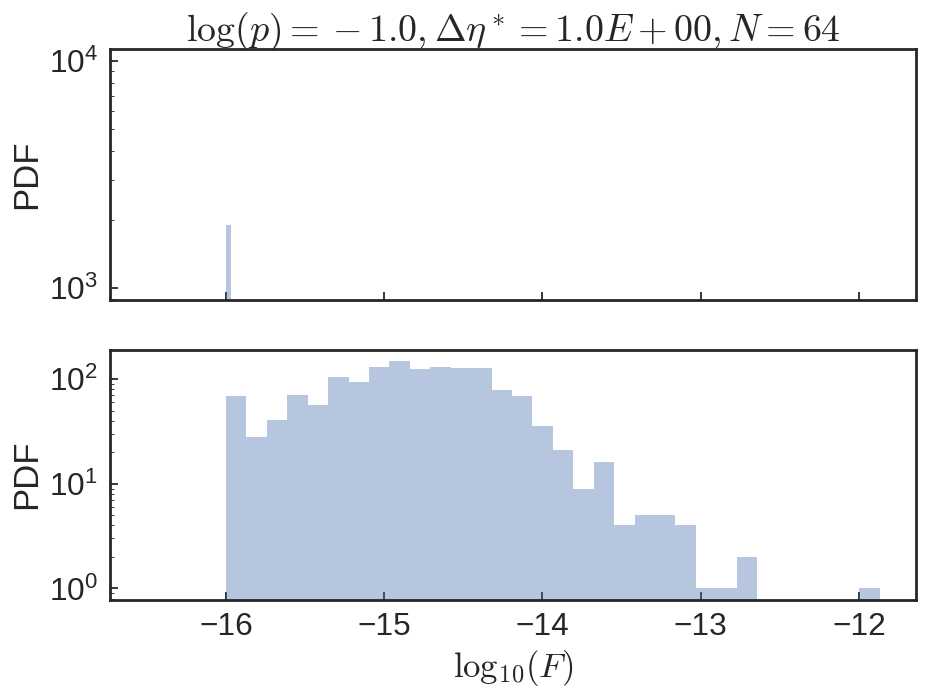

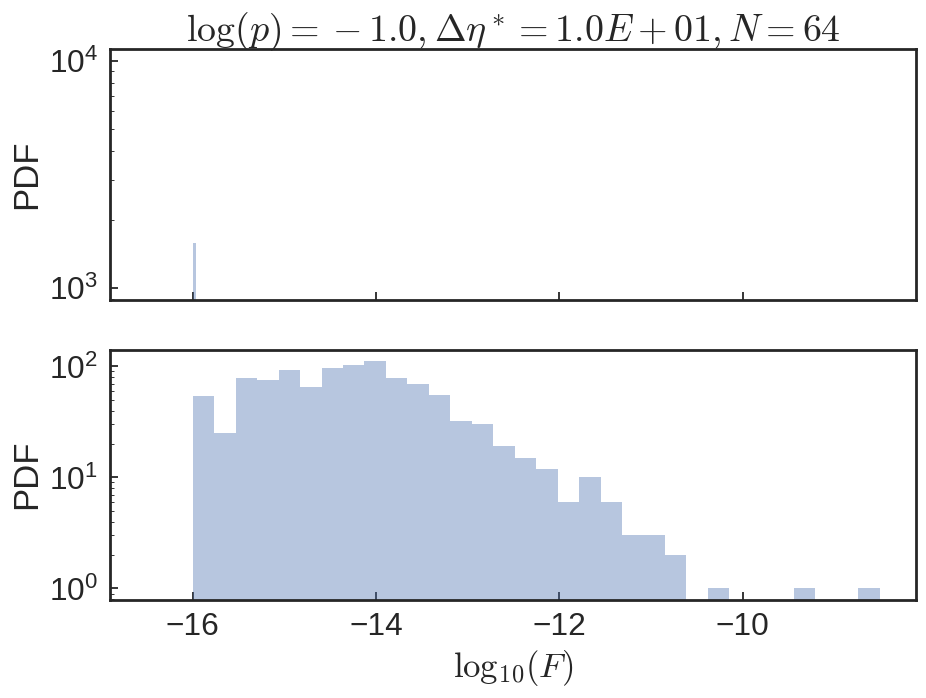

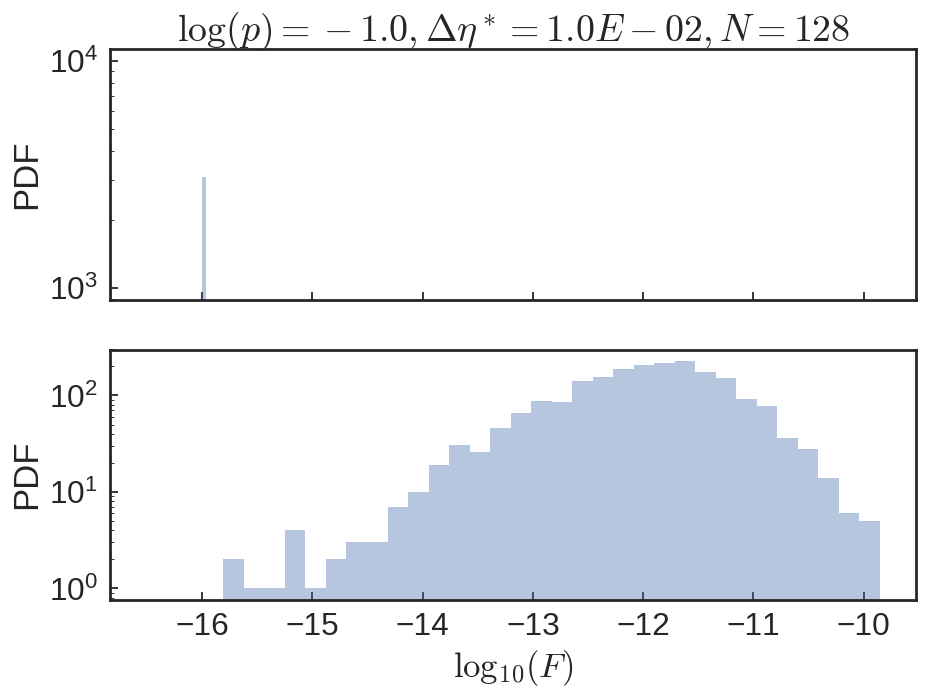

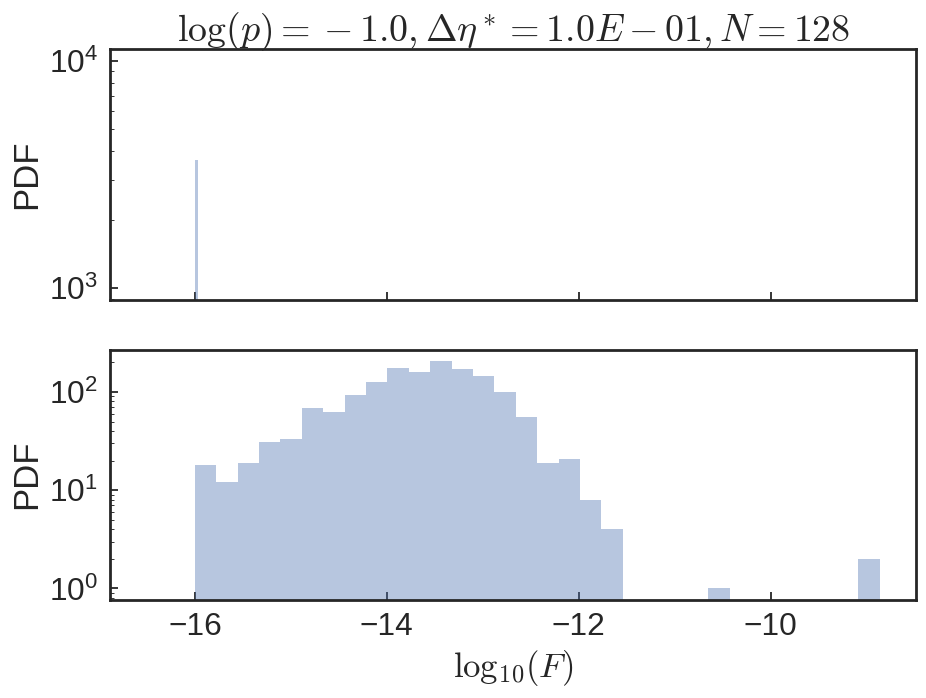

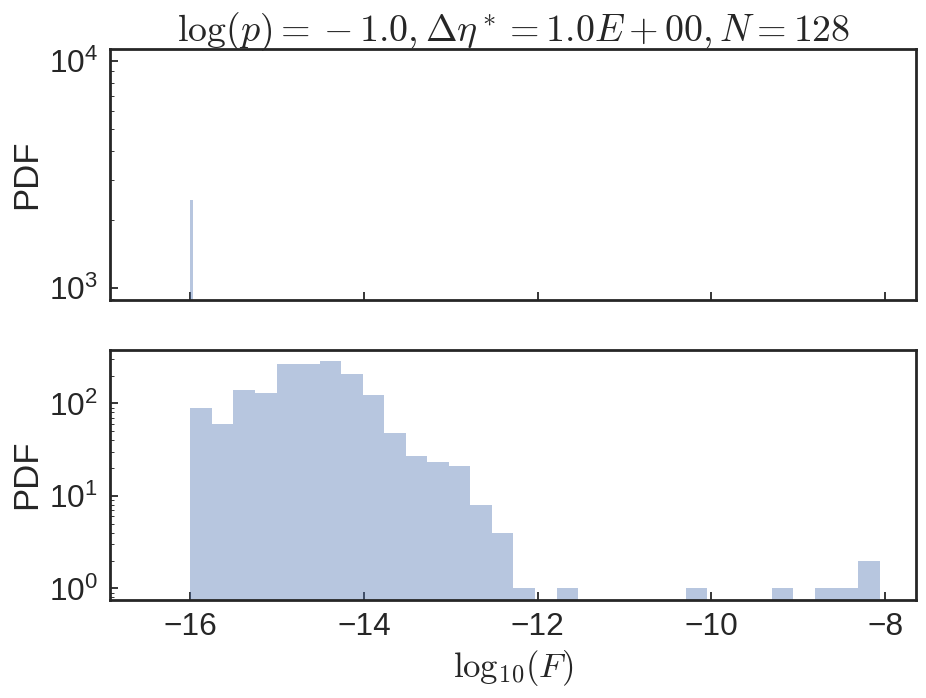

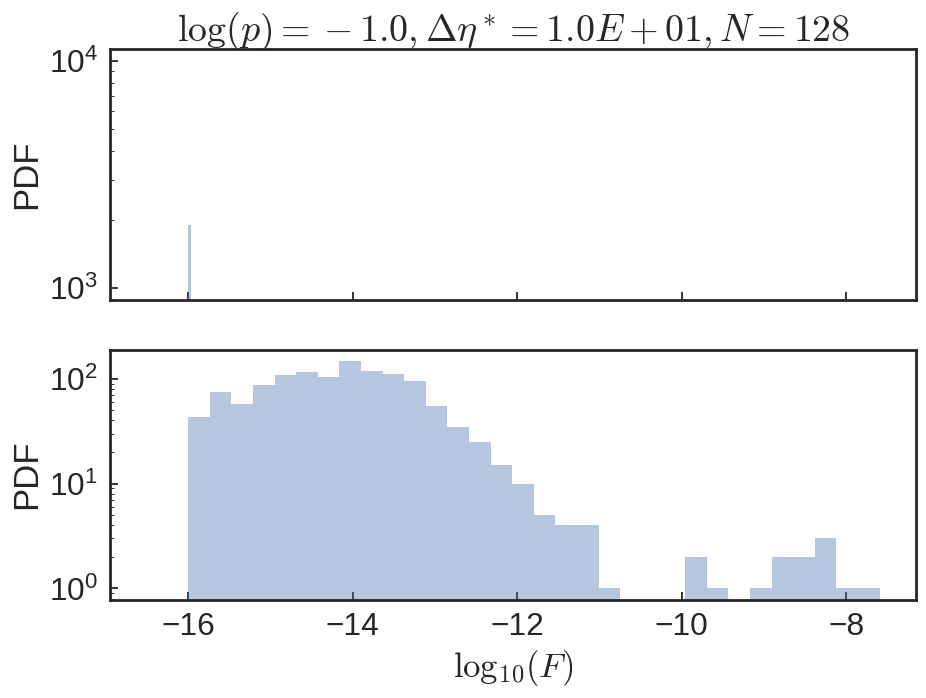

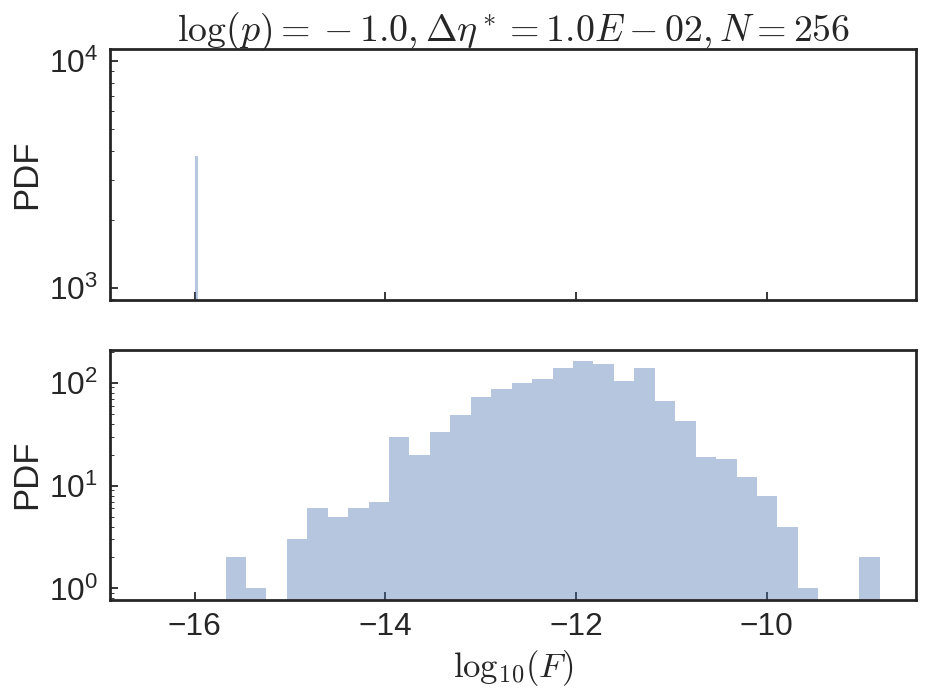

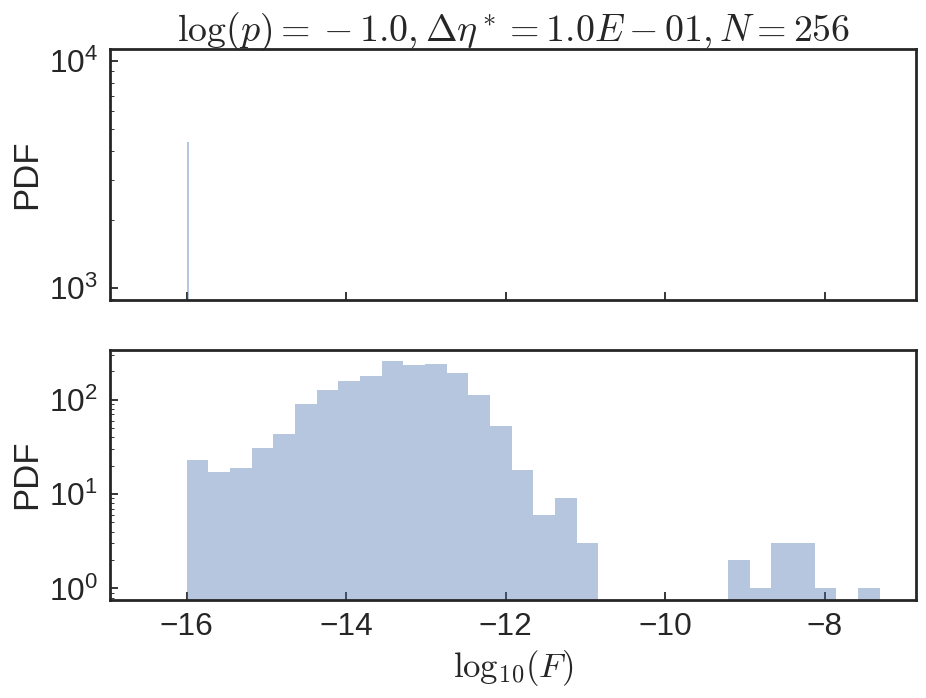

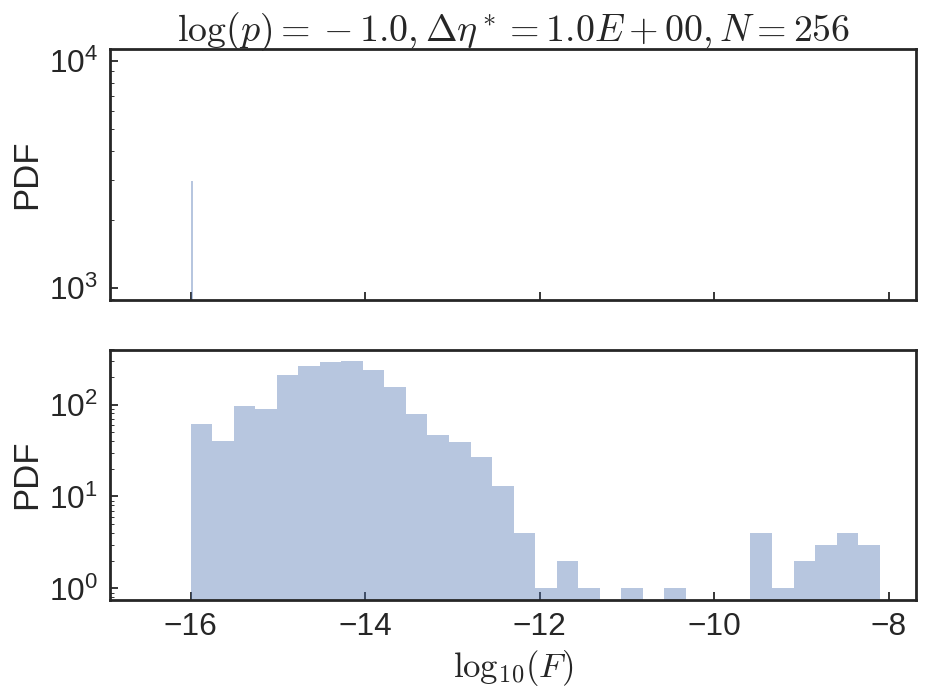

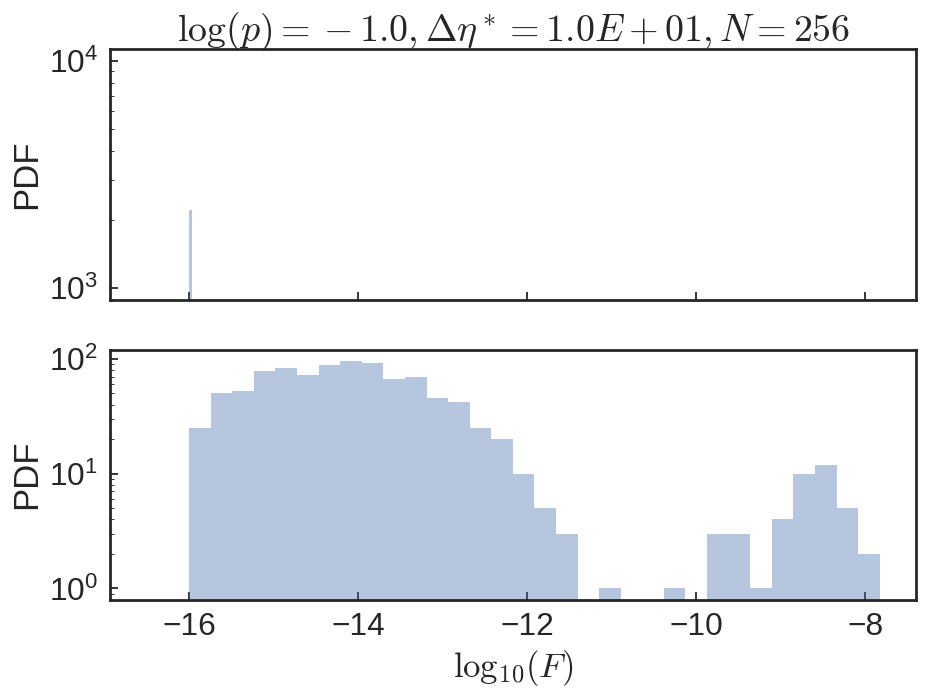

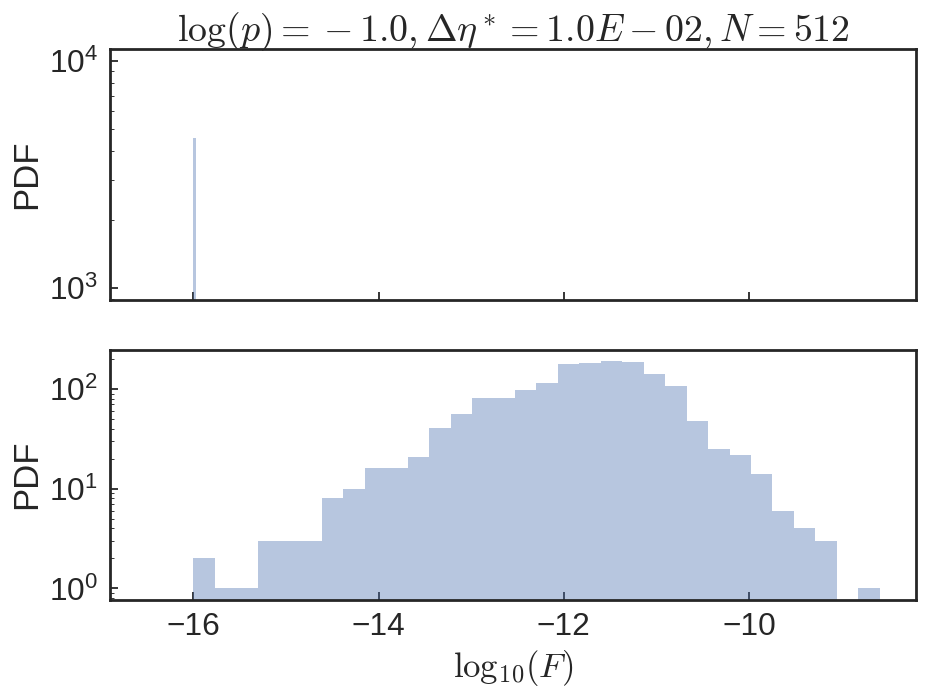

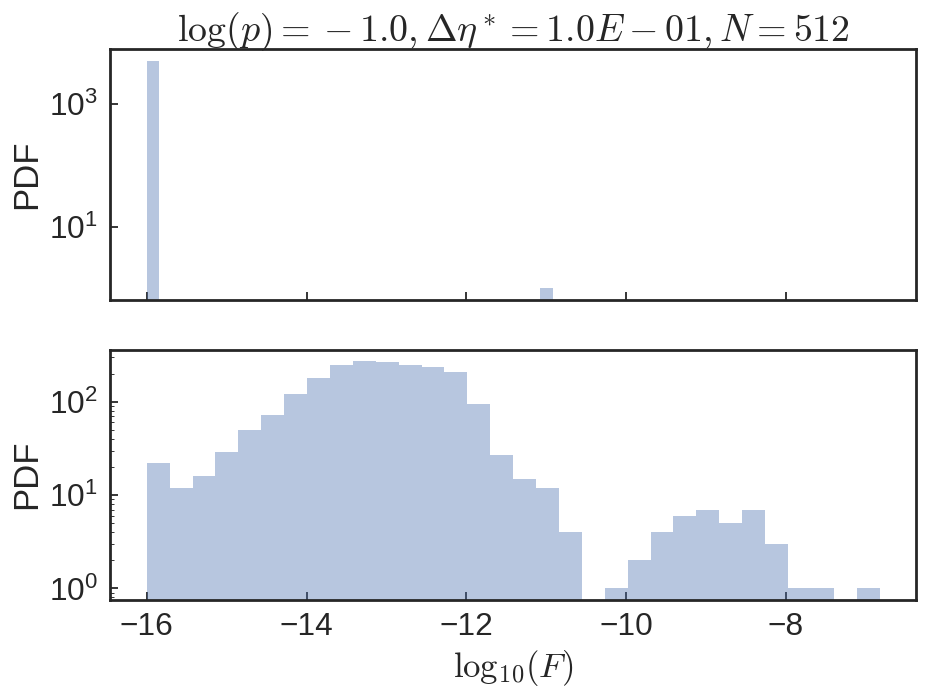

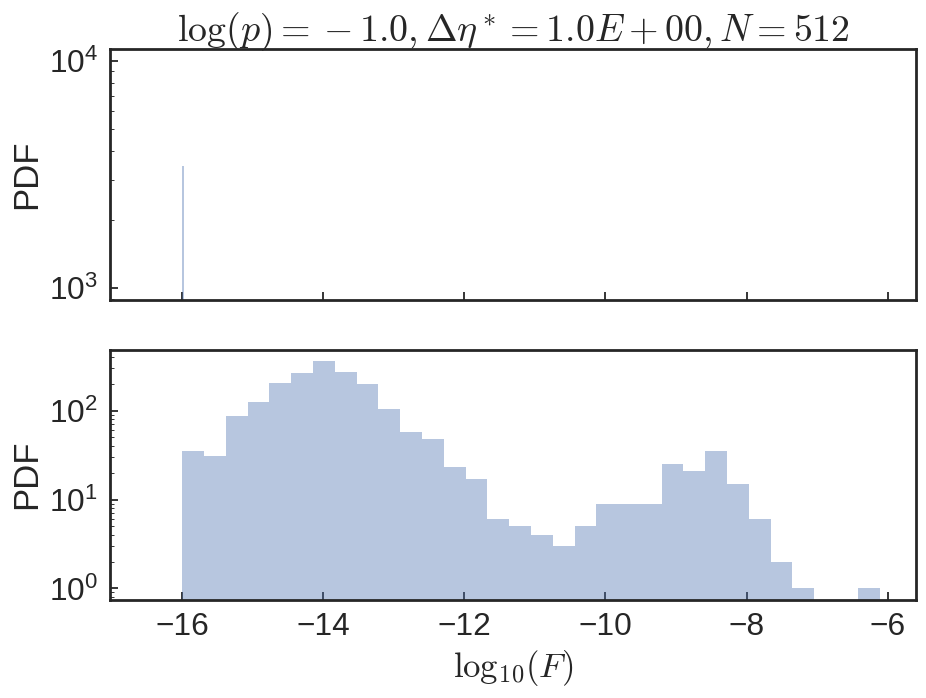

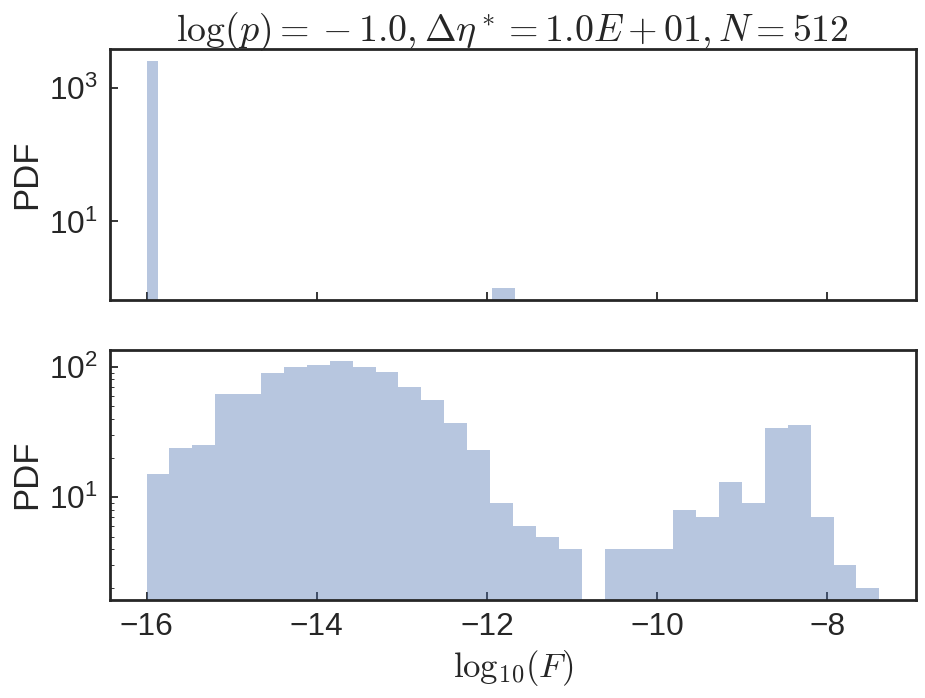

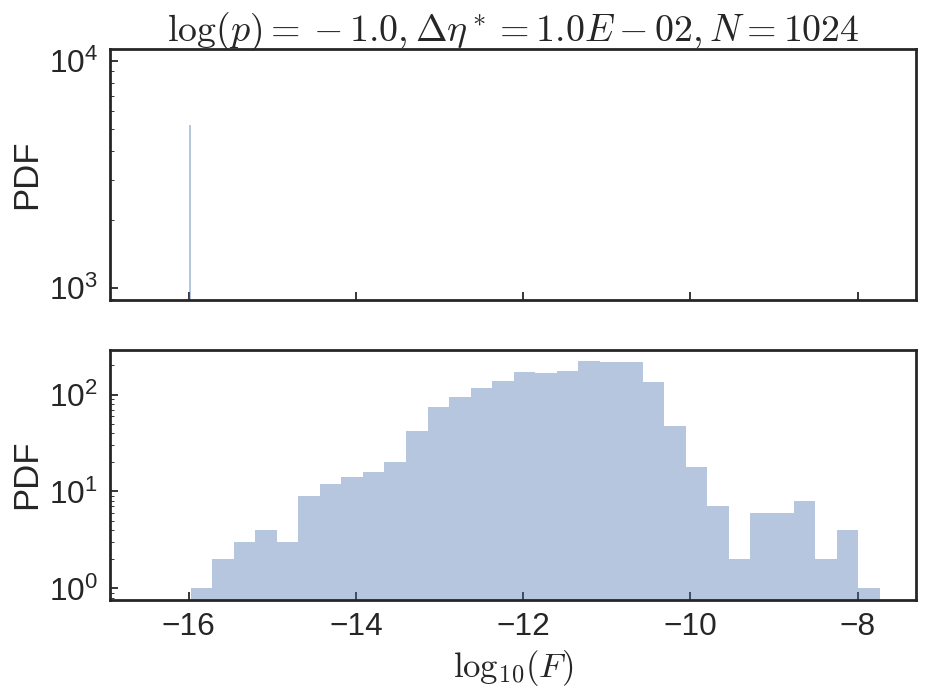

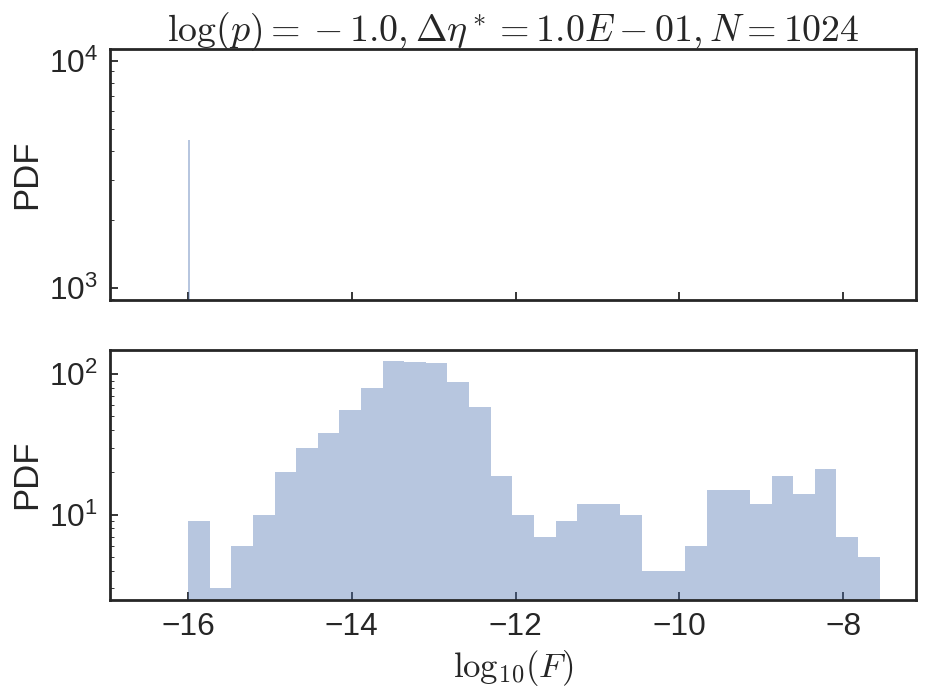

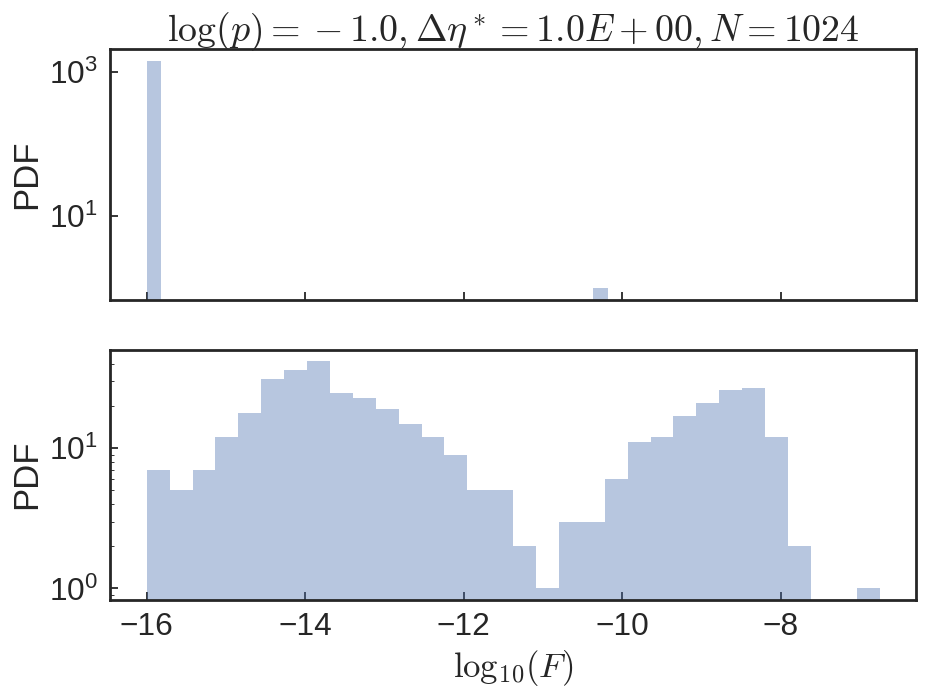

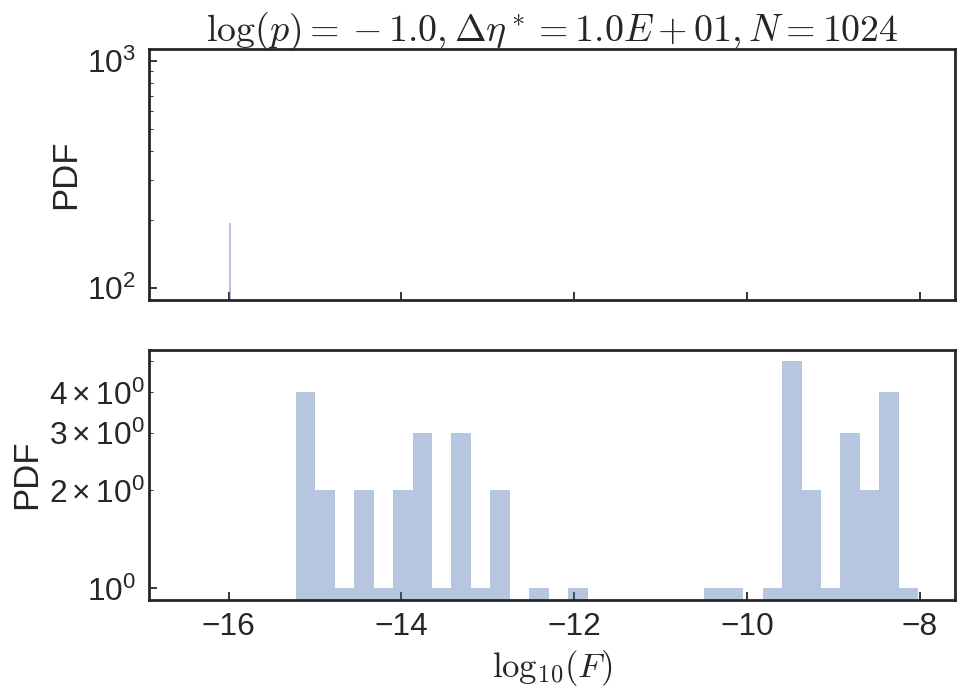

ValueError: x must be 1D or 2D

In [66]:
for (NN, Lp, eta), group in df[df.success_flag!=2.0].groupby(['NN', 'Lp', 'eta']):

#     if NN < 512:
#         continue
    
#     for NTS, group in group1.groupby('NTS'):
#         print NTS
            
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
                
    sns.distplot(np.log10(np.abs(group[group.obj_func < tol]['obj_error'])+1e-16), kde=False, ax=ax1, bins = 32, norm_hist=False, color='b')
#     ax1.vlines(np.log10(np.finfo(float).eps), 1e-4, 3e0)
#     ax1.vlines(np.log10(tol), 1e-4, 3e0, color='b')
    ax1.set_yscale('log')
    # ax1.set_xscale('symlog', linthreshx=1e-10)
#     ax1.set_xlim(-3, 0)
#     ax1.set_ylim(1e-4, 3e0)
    ax1.set_xlabel("")
    ax1.set_ylabel("PDF")
    ax1.set_title(r'$\log(p)={0:.1f}, \Delta\eta^*={1:.1E}, N={2:d}$'.format(Lp, eta, int(NN)))
    
    sns.distplot(np.log10(np.abs(group[group.obj_func > tol]['obj_error'])+1e-16), kde=False, ax=ax2, bins = 32, norm_hist=False, color='b')
#     ax2.vlines(np.log10(np.finfo(float).eps), 1e-1, 1e0)
#     ax2.vlines(np.log10(tol), 1e-1, 1e0, color='b')
    ax2.set_yscale('log')
    # ax2.set_xscale('symlog', linthreshx=1e-10)
    # ax2.set_xlim(-1, 1)
#     ax1.set_xlim(-4, 0)
#     ax2.set_ylim(1e-1, 1e0)
    ax2.set_xlabel(r"$\log_{10} (F)$")
    ax2.set_ylabel("PDF")
    plt.show()

In [123]:
for NN, group in df[df.success_flag!=2.0].groupby('NN'):

#     for NTS, group in group1.groupby('NTS'):
#         print NTS
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    
    sns.distplot(np.log10(np.abs(group[group.obj_func < tol]['min_eval'])), kde=False, ax=ax1, bins = 32, norm_hist=False, color='b')
#     ax1.vlines(np.log10(np.finfo(float).eps), 1e-4, 3e0)
#     ax1.vlines(np.log10(tol), 1e-4, 3e0, color='b')
    ax1.set_yscale('log')
    # ax1.set_xscale('symlog', linthreshx=1e-10)
#     ax1.set_xlim(-3, 0)
#     ax1.set_ylim(1e-4, 3e0)
    ax1.set_xlabel("")
    ax1.set_ylabel("PDF")
    ax1.set_title("$N={0:d}$".format(int(NN)))

    sns.distplot(np.log10(np.abs(group[group.obj_func < tol]['min_eval'])), kde=False, ax=ax2, bins = 32, norm_hist=False, 
                 hist_kws={'cumulative': True}, color='b')
#     ax2.vlines(np.log10(np.finfo(float).eps), 1e-1, 1e0)
#     ax2.vlines(np.log10(tol), 1e-1, 1e0, color='b')
    ax2.set_yscale('log')
    # ax2.set_xscale('symlog', linthreshx=1e-10)
    # ax2.set_xlim(-1, 1)
#     ax1.set_xlim(-4, 0)
#     ax2.set_ylim(1e-1, 1e0)
    ax2.set_xlabel(r"$\log_{10} (F)$")
    ax2.set_ylabel("PDF")
    plt.show()

TypeError: bad operand type for abs(): 'NoneType'

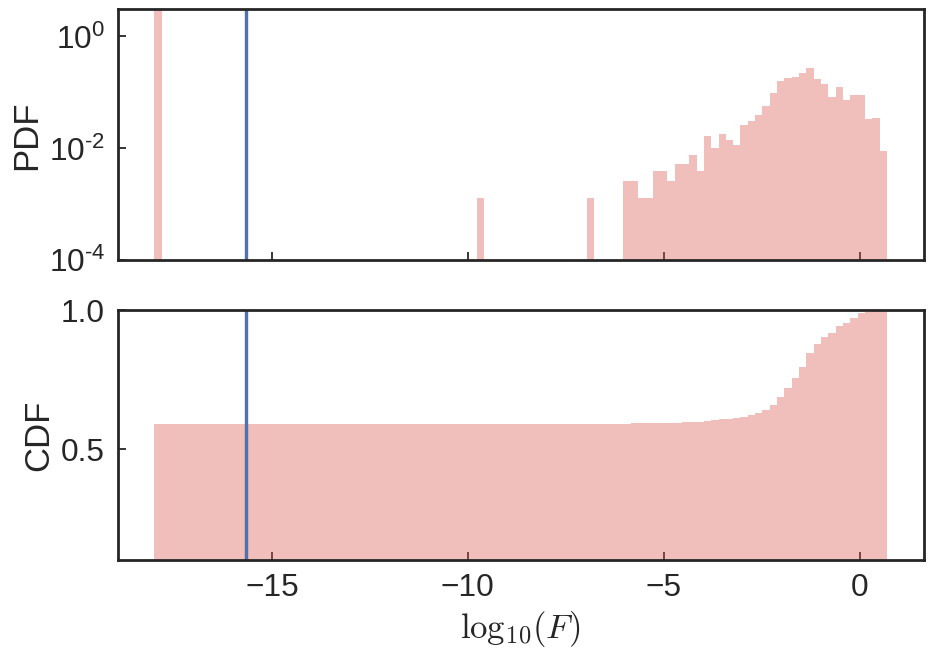

2.22044604925e-16


In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.distplot(np.log10(df[df.success_flag!=2.0]['obj_func']+1e-18), kde=False, ax=ax1, bins = 100, norm_hist=True)
ax1.vlines(np.log10(np.finfo(float).eps), 1e-4, 3e0)
ax1.vlines(np.log10(tol), 1e-4, 3e0, color='b')
ax1.set_yscale('log')
# ax1.set_xscale('symlog', linthreshx=1e-10)
# ax1.set_xlim(-1, 1)
ax1.set_ylim(1e-4, 3e0)
ax1.set_xlabel("")
ax1.set_ylabel("PDF")
# ax1.set_title("$N={0:d}$".format(int(NN)))

sns.distplot(np.log10(df[df.success_flag!=2.0]['obj_func']+1e-18), kde=False, ax=ax2, bins = 100, hist_kws={'cumulative': True},
            norm_hist=True)
ax2.vlines(np.log10(np.finfo(float).eps), 1e-1, 1e0)
ax2.vlines(np.log10(tol), 1e-1, 1e0, color='b')
# ax2.set_yscale('log')
# ax2.set_xscale('symlog', linthreshx=1e-10)
# ax2.set_xlim(-1, 1)
ax2.set_ylim(1e-1, 1e0)
ax2.set_xlabel(r"$\log_{10} (F)$")
ax2.set_ylabel("CDF")
plt.show()

print tol

1e-14


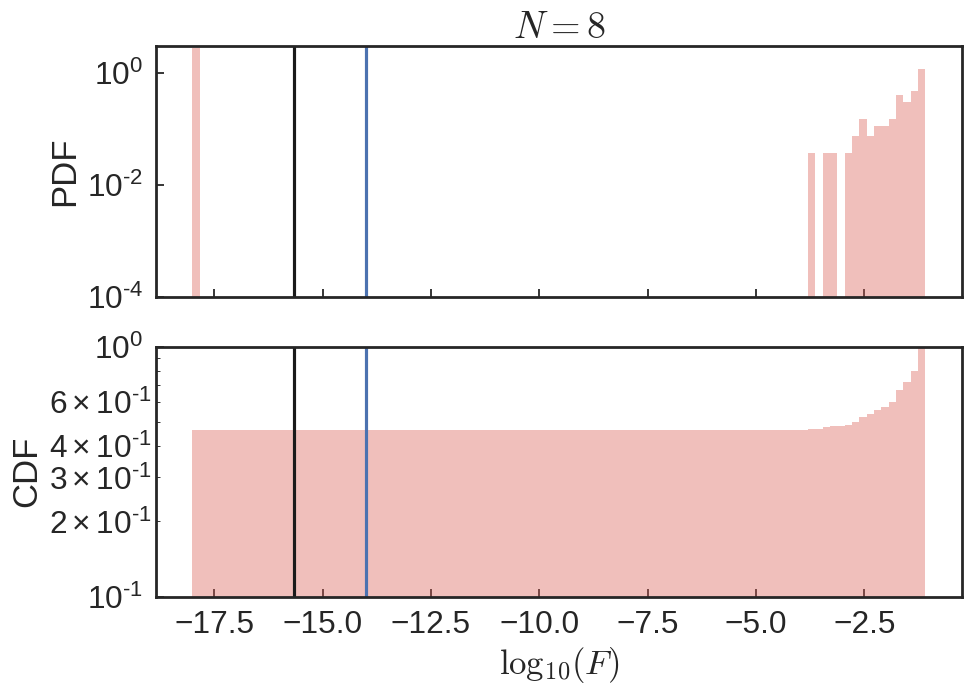

1e-14


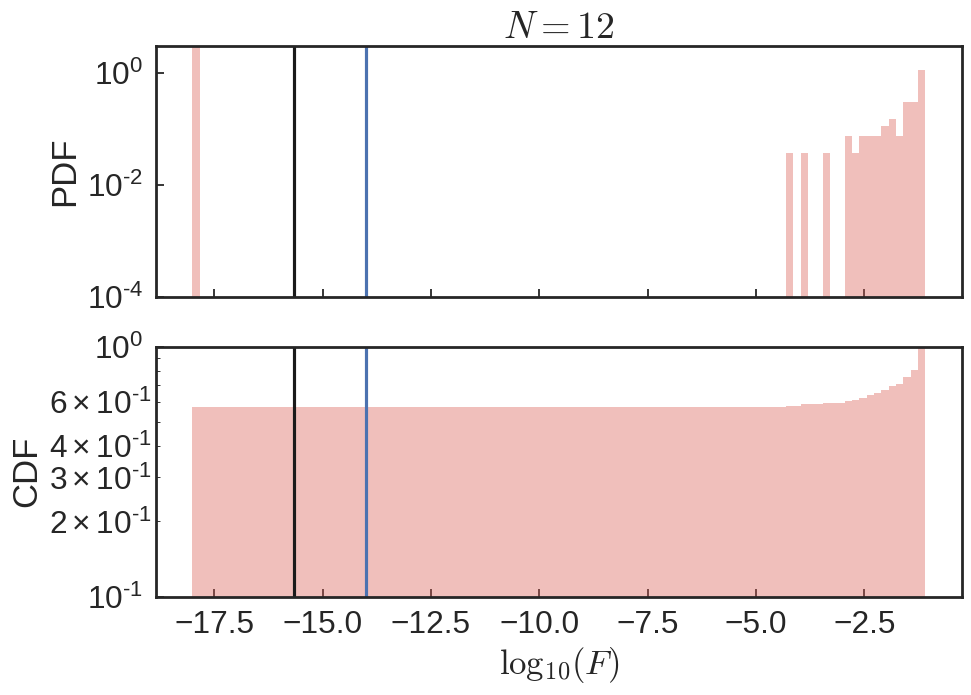

1e-14


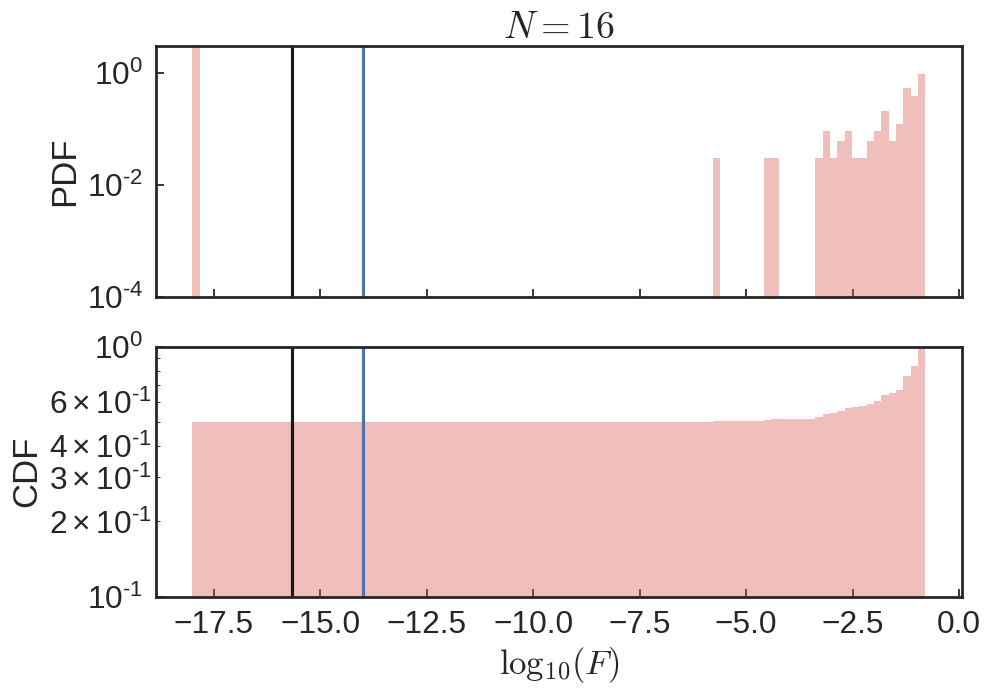

1e-14


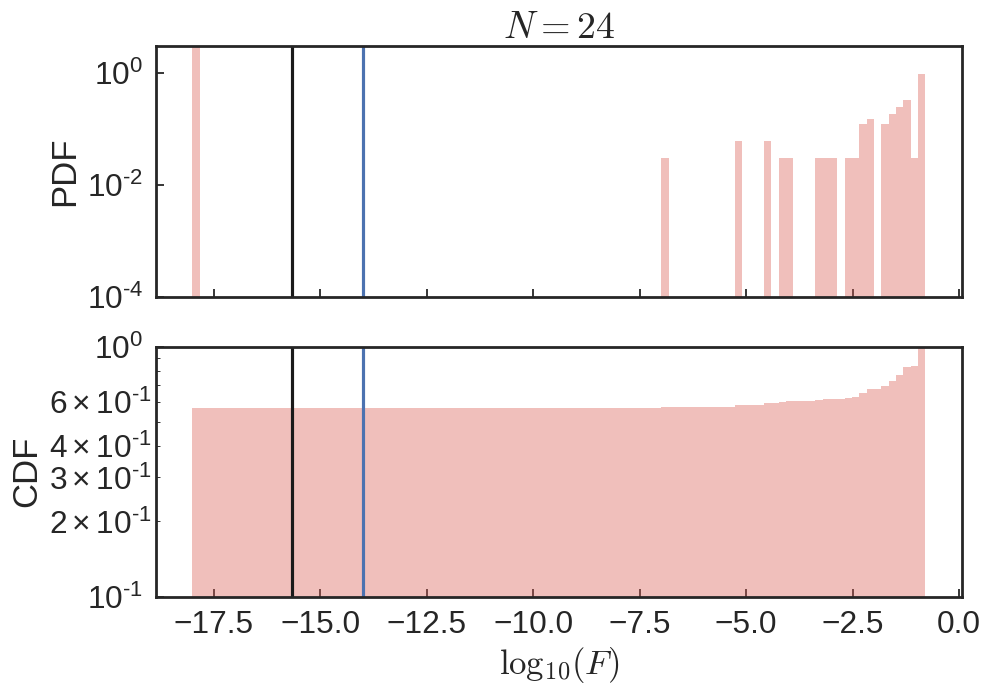

1e-14


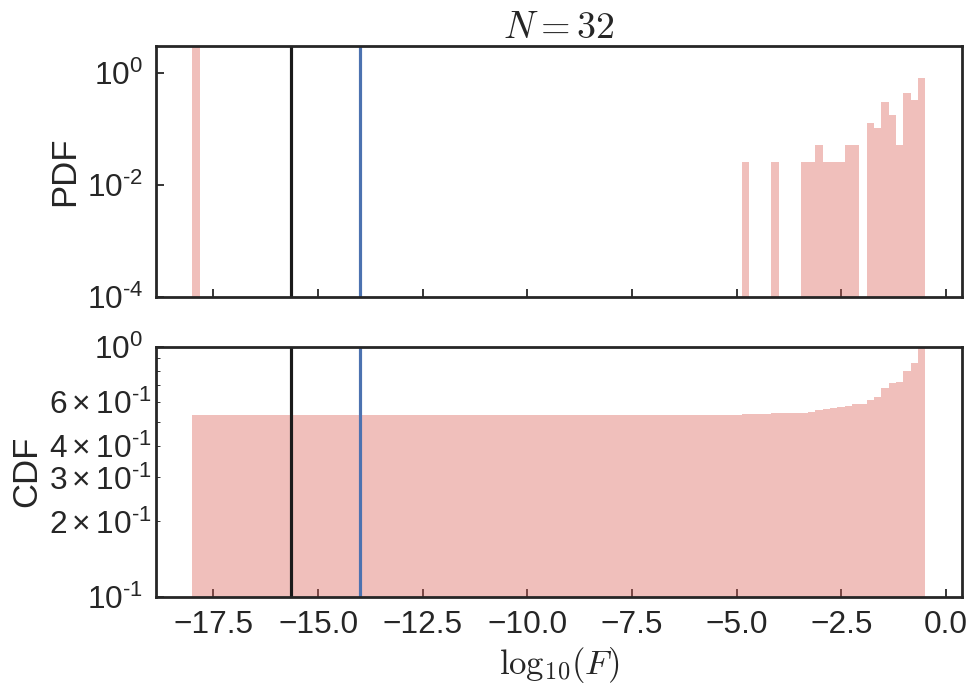

1e-14


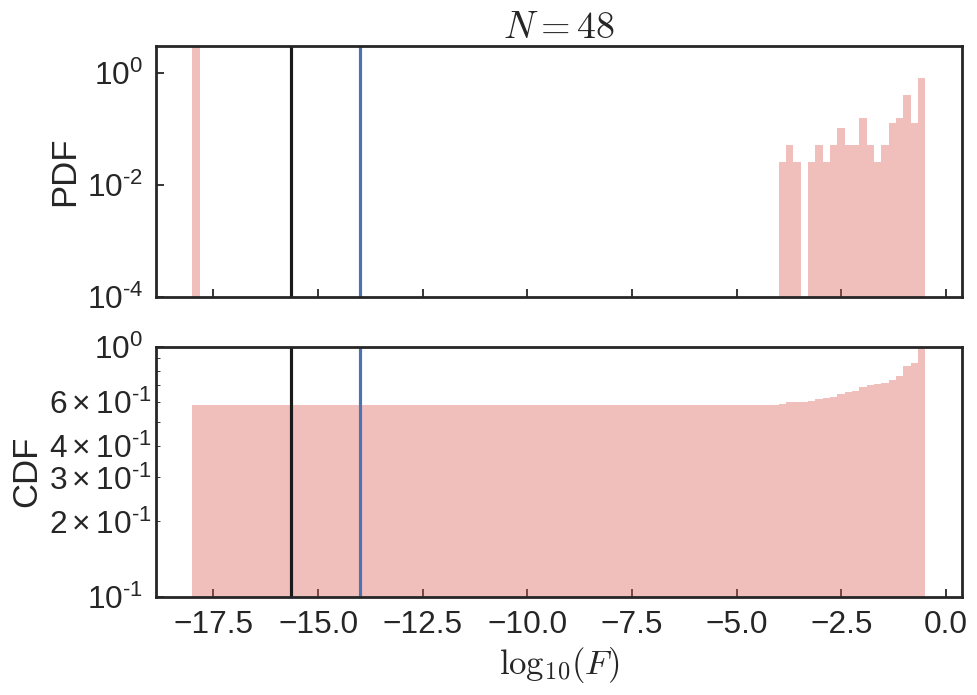

1e-14


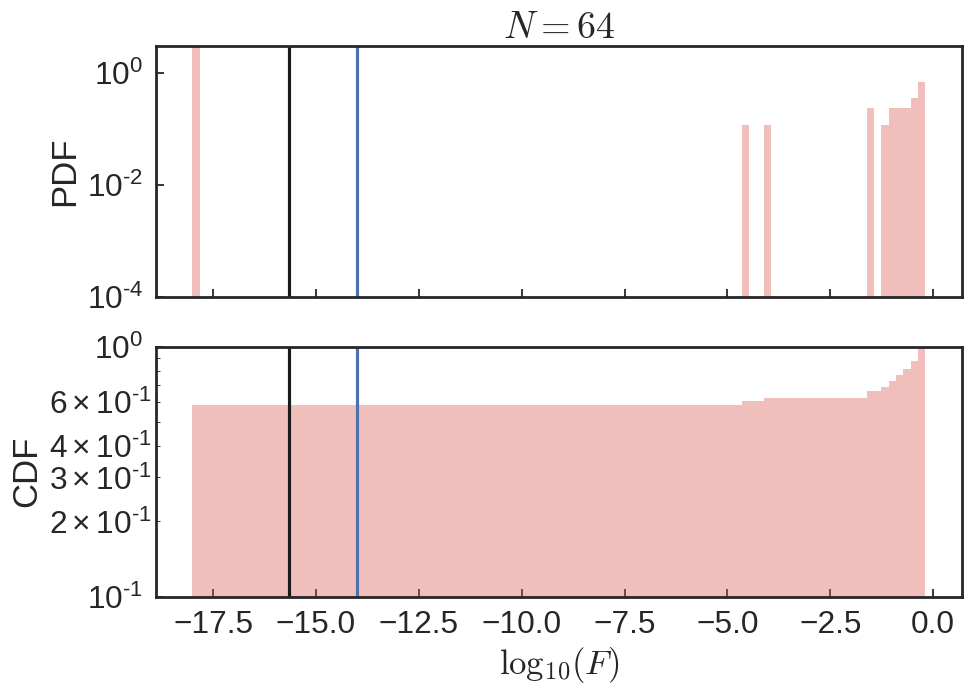

In [80]:
for NN, group in df[df.success_flag!=2.0].groupby('NN'):

#     for NTS, group in group1.groupby('NTS'):
#         print NTS
    
    print tol
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    sns.distplot(np.log10(group['obj_func']+1e-18), kde=False, ax=ax1, bins = 100, norm_hist=True)
    ax1.vlines(np.log10(np.finfo(float).eps), 1e-4, 3e0)
    ax1.vlines(np.log10(tol), 1e-4, 3e0, color='b')
    ax1.set_yscale('log')
    # ax1.set_xscale('symlog', linthreshx=1e-10)
    # ax1.set_xlim(-1, 1)
    ax1.set_ylim(1e-4, 3e0)
    ax1.set_xlabel("")
    ax1.set_ylabel("PDF")
    ax1.set_title("$N={0:d}$".format(int(NN)))

    sns.distplot(np.log10(group['obj_func']+1e-18), kde=False, ax=ax2, bins = 100, hist_kws={'cumulative': True},
                norm_hist=True)
    ax2.vlines(np.log10(np.finfo(float).eps), 1e-1, 1e0)
    ax2.vlines(np.log10(tol), 1e-1, 1e0, color='b')
    ax2.set_yscale('log')
    # ax2.set_xscale('symlog', linthreshx=1e-10)
    # ax2.set_xlim(-1, 1)
    ax2.set_ylim(1e-1, 1e0)
    ax2.set_xlabel(r"$\log_{10} (F)$")
    ax2.set_ylabel("CDF")
    plt.show()

In [ ]:

x_list = {}
y_list = {}

for n in 2**np.arange(3, 9):
    x_list[n] = []
    y_list[n] = []

for (Lp, eta) in sorted(NN_list):
    
    for i in range()
    
    x_list[NN_list[(Lp, eta)]].append(eta)
    y_list[NN_list[(Lp, eta)]].append(NTc_list[(Lp, eta)])


fig, ax1 = plt.subplots()

ax1.plot(eta_list, alpha_list, 'go-')

ax1.set_ylabel(r'Finite Size Exponent $\alpha$')
ax1.set_xlabel(r'$|\Delta \eta^*|$')

plt.show()



8.0
[ 1.64224309  0.68407775]
[ 0.03426027  0.03597219]
0.0 3.0
16.0
[ 1.49126425  0.55180855]
[ 0.01823329  0.02154824]
0.0 3.0
32.0
[ 1.26023613  0.43699584]
[ 0.00989004  0.01340189]
0.0 2.0
64.0
[ 1.23149657  0.40243583]
[ 0.0109845   0.01165805]
0.0 2.0
128.0
[ 1.19291421  0.3868322 ]
[ 0.00896401  0.01000509]
0.0 2.0
256.0
[ 1.19430218  0.40468367]
[ 0.0091279   0.01161404]
0.0 2.0
512.0
[ 1.20668061  0.3826272 ]
[ 0.00867065  0.01042743]
0.0 2.0


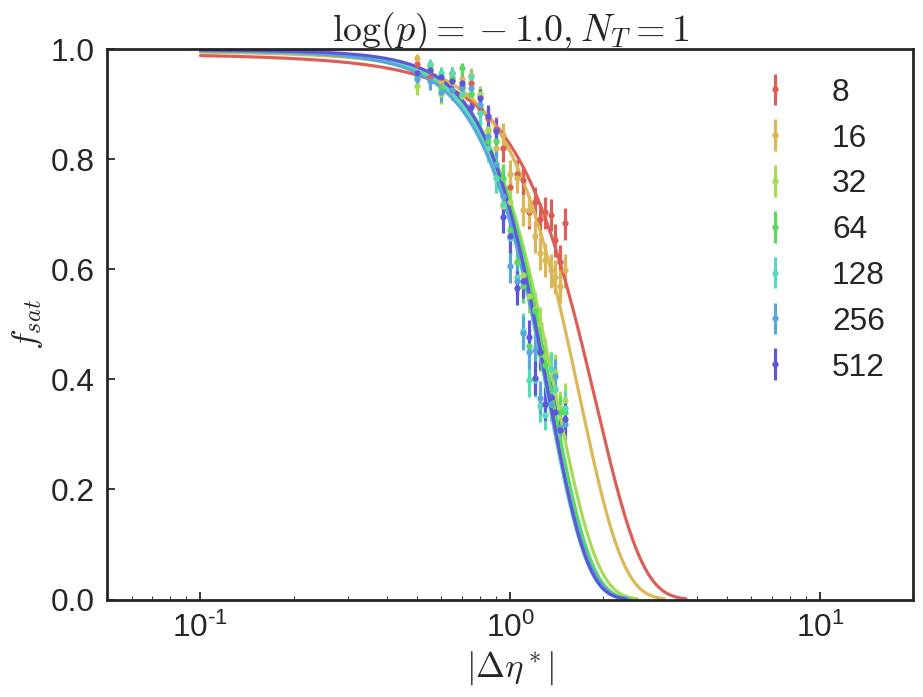

8.0
[-1.36102999  1.54911347]
[ 0.28347434  0.19378665]
-4.0 2.0
16.0
[-0.02271366  1.0792239 ]
[ 0.07971999  0.08137661]
-2.0 2.0
32.0
[-0.07938138  0.94868127]
[ 0.07690792  0.06966362]
-2.0 2.0
64.0
[-0.00194757  0.77719007]
[ 0.05625596  0.04638184]
-2.0 2.0
128.0
[ 0.12188226  0.67830998]
[ 0.04588862  0.03982974]
-1.0 1.0
256.0
[ 0.07370965  0.75393731]
[ 0.04780556  0.04120825]
-1.0 2.0
512.0
[ 0.03828569  0.79229957]
[ 0.06723688  0.05961463]
-2.0 2.0


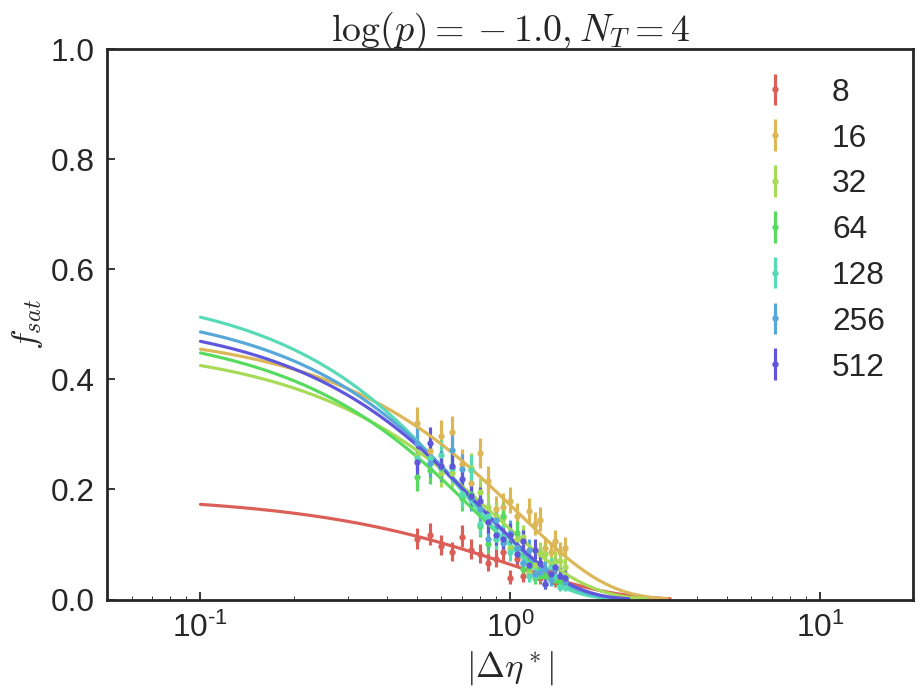

{(-1.0, 4.0): [-1.3610299923400577, -0.022713655653436627, -0.07938138473629254, -0.0019475745565568795, 0.12188225813712579, 0.073709647868586525, 0.038285686626535059], (-1.0, 1.0): [1.6422430890976358, 1.4912642458644623, 1.2602361339415185, 1.2314965736808194, 1.1929142075582813, 1.1943021787851547, 1.2066806069795404]}


In [128]:
def binomMLE(x, y, dist_param, func, jac=None, p0=None):
    
    n = dist_param.astype(np.int)
    k = (n*y).astype(np.int)
        
    fit_func = lambda theta: -np.sum(k * np.log(func(x, *theta) + np.sqrt(np.finfo(float).eps)) 
                                          + (n - k) * np.log(1.0 - func(x, *theta) + np.sqrt(np.finfo(float).eps)))
    
#     fit_jac = lambda theta: np.array([-np.sum((k * 1.0/(func(x, *theta) + 1e-12) 
#                                           - (n - k) * 1.0/(1.0 - func(x, *theta) + 1e-12))* jac(x, *theta)[0]),
#                                      -np.sum((k * 1.0/(func(x, *theta) + 1e-12) 
#                                           - (n - k) * 1.0/(1.0 - func(x, *theta) + 1e-12))* jac(x, *theta)[1])])
    
    res = spo.minimize(fit_func, p0, jac=None,
                       method='BFGS', options={'gtol': np.sqrt(np.finfo(float).eps), 'disp': False})
    
#     print res
    
    return res.x

def mcError(x, y, dist_param, fit_func, p0, dist="gaussian", bounds=(-np.inf, np.inf), nresample=100, plot=False):
    
    p = np.zeros([len(p0), nresample], float)
    
    x = np.array(x, float)
    y = np.array(y, float)
    dist_param = np.array(dist_param, float)
        
    for n in range(nresample):
#         if n % 100 == 0:
#             print n

        y_tmp = np.array(rand.binomial(dist_param.astype(int), y) / dist_param)

        avg =  binomMLE(x, y_tmp, dist_param, fit_func, jac=None, p0=p0)
        
        p[:, n] = avg
    
    if plot:
    
        fig, axes = plt.subplots(1, len(p0), figsize=(24, 8))
        for i in range(len(p0)):
            sns.distplot(p[i], ax=axes[i], rug=True, rug_kws={"color": "g"},
                         kde_kws={"color": "k", "lw": 3},
                         hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"})
    
    return np.mean(p, axis=1), np.std(p, axis=1), sp.stats.skew(p, axis=1)



func = lambda x, mu, sigma : 0.5*sp.special.erfc((x-mu) / sigma / np.sqrt(2))
jac = lambda x, mu, sigma : np.array([1.0/np.sqrt(np.pi * sigma**2) * np.exp((x-mu)**2 / sigma**2),
                            (x-mu)/np.sqrt(np.pi * sigma**2) * np.exp((x-mu)**2 / sigma**2)])

                                     
NN_list = {}
NE_list = {}
NTc_list = {}
NTc_err_list = {}
w_list = {}
w_err_list = {}

for (Lp, NT), group0 in df_agg.groupby(['Lp', 'NTS']):

    palette = it.cycle(sns.color_palette())

    fig, ax1 = plt.subplots()

    NN_list[(Lp, NT)] = []
    NE_list[(Lp, NT)] = []
    NTc_list[(Lp, NT)] = []
    NTc_err_list[(Lp, NT)] = []
    w_list[(Lp, NT)] = []
    w_err_list[(Lp, NT)] = []

    for NN, group1 in group0.groupby('NN'):

        color = next(palette)

        eta = np.array(group1['eta'])
        count = np.array(group1['count'])

        fsat = np.array(group1['fsat'])

        fsat_low = np.array(group1['fsat_err_low'])
        fsat_up = np.array(group1['fsat_err_up'])

        NE = np.mean(group1['NE'])


        ax1.errorbar(eta, fsat, 
                    yerr=[fsat_low, fsat_up], fmt=".", label="{:}".format(int(NN)), 
                     color=color)




        avg, std, skew = mcError(eta, fsat, count, func, [10.0, 20.0], 
                       dist="binomial", bounds=([-50, 0.0], [300, 100]), plot=False, nresample=100)

#         avg =  binomMLE(NT, fsat, count, func, jac=None, p0=[0, 10])

        print NN
        print avg
        print std
#         print skew

        sigma = 2
        print np.round(avg[0]-sigma*avg[1]), np.round(avg[0]+sigma*avg[1])


        ax1.plot(np.linspace(0.1,avg[0]+3*avg[1], 1000), func(np.linspace(0.1, avg[0]+3*avg[1], 1000), *avg), color=color)

        NN_list[(Lp, NT)].append(NN)
        NE_list[(Lp, NT)].append(NE)
        NTc_list[(Lp, NT)].append(avg[0])
        NTc_err_list[(Lp, NT)].append(std[0])
        w_list[(Lp, NT)].append(avg[1])
        w_err_list[(Lp, NT)].append(std[1])



#     for i in range(0, 11):
#         ax1.vlines(2**i, 0, 1.0, color='k', linestyle='dashed', linewidth=0.5)


    ax1.legend(loc="upper right")
    ax1.set_xlabel(r'$|\Delta \eta^*|$')
    ax1.set_ylabel(r'$f_{sat}$')
    ax1.set_xlim(0.5e-1, 2e1)
    ax1.set_xscale('log')
    ax1.set_ylim(0,1)
    ax1.set_title(r'$\log(p)={0:.1f}, N_T={1:.0f}$'.format(Lp, NT))

    # plt.savefig("prob_success_err.png")
    # plt.savefig("fsat_slice_2D.eps")

    plt.show()
    
print NTc_list

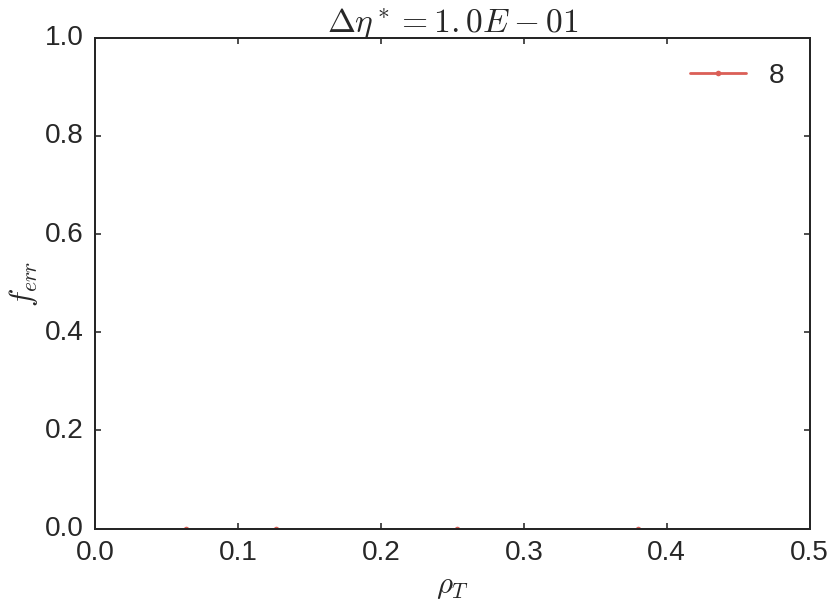

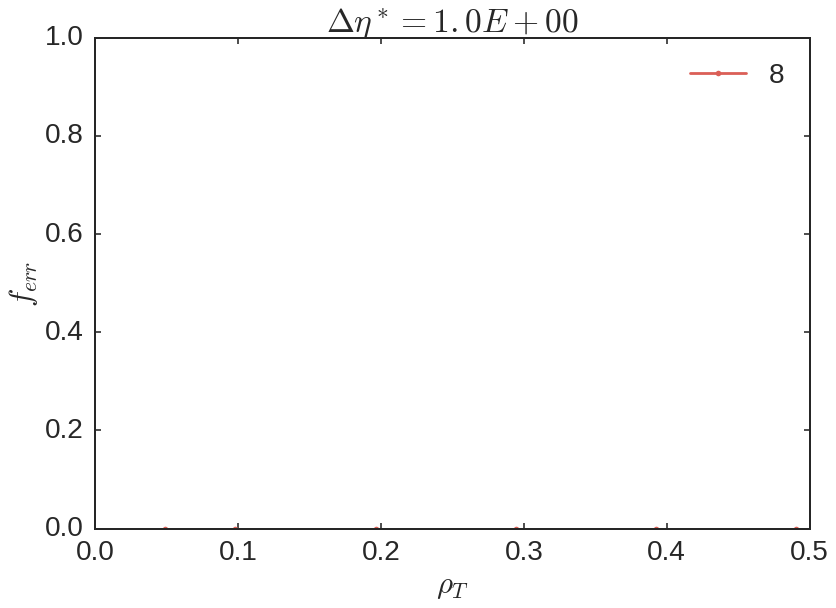

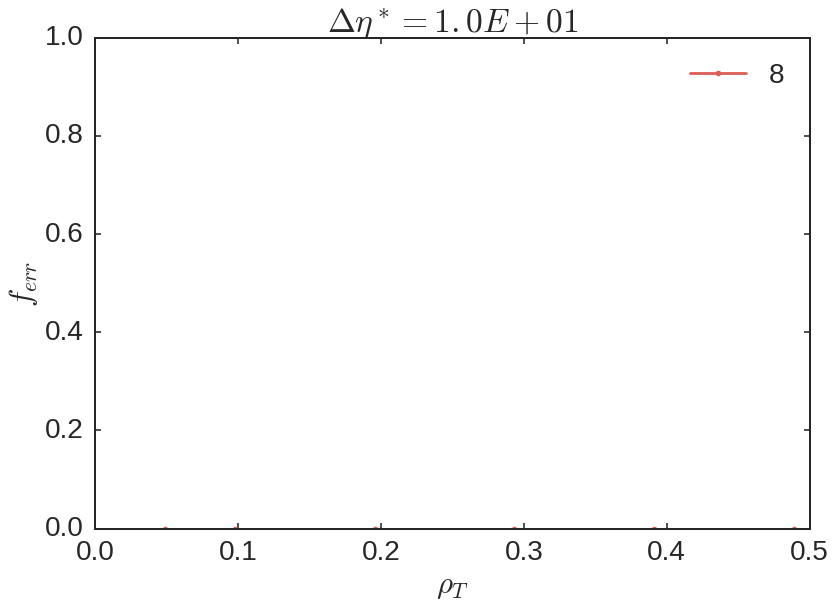

In [29]:


func = lambda x, mu, sigma : 0.5*(1-sp.special.erf((x-mu) / sigma / np.sqrt(2)))

for eta, group0 in df_agg.groupby('eta'):

    palette = it.cycle(sns.color_palette())

    fig, ax1 = plt.subplots()
    
    for NN, group1 in group0.groupby('NN'):

    #     if NN > 128:
    #         continue

    #     index = NN_list.index(NN)

        color = next(palette)

        NT = np.array(group1['NTS'])
        
        NE = np.mean(group1['NE'])

        tot = np.array(group1['count'] + group1['err_count'])
        err_count = np.array(group1['err_count'])

        
    #     ax1.plot(np.linspace(0, 200, 1000) / NB, func(np.linspace(0, 200, 1000), rhoc_list[index], width_list[index]), color=color)

        ax1.plot(NT / NE, err_count / tot, ".-", label="{:}".format(int(NN)), 
                     color=color)





    ax1.legend(loc="upper right")
    ax1.set_xlabel(r'$\rho_T$')
    ax1.set_ylabel(r'$f_{err}$')
    ax1.set_xlim(0, 0.5)
    ax1.set_ylim(0.0, 1.0)
#     ax1.set_yscale('log')
    ax1.set_title(r'$\Delta\eta^*={:.1E}$'.format(eta))

    # plt.savefig("prob_success_err.png")
    # plt.savefig("fsat_slice_2D.eps")

    plt.show()

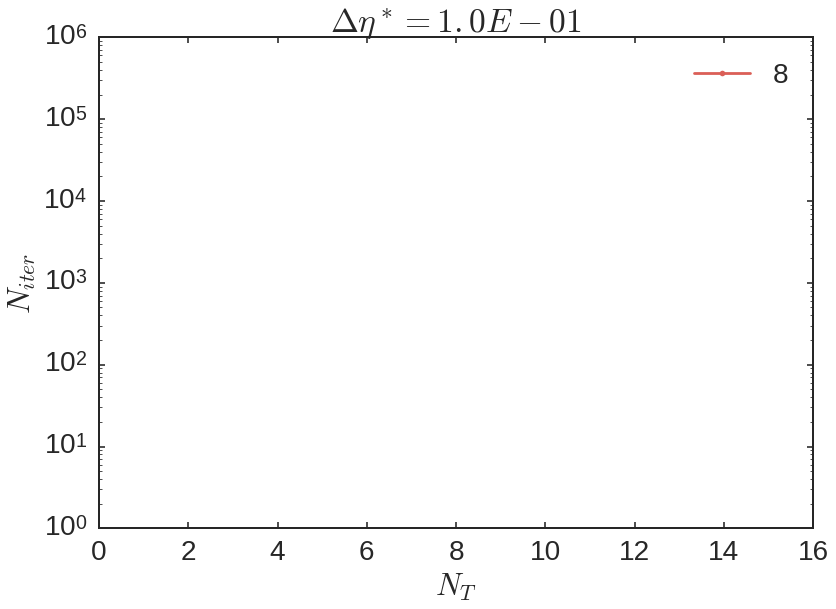

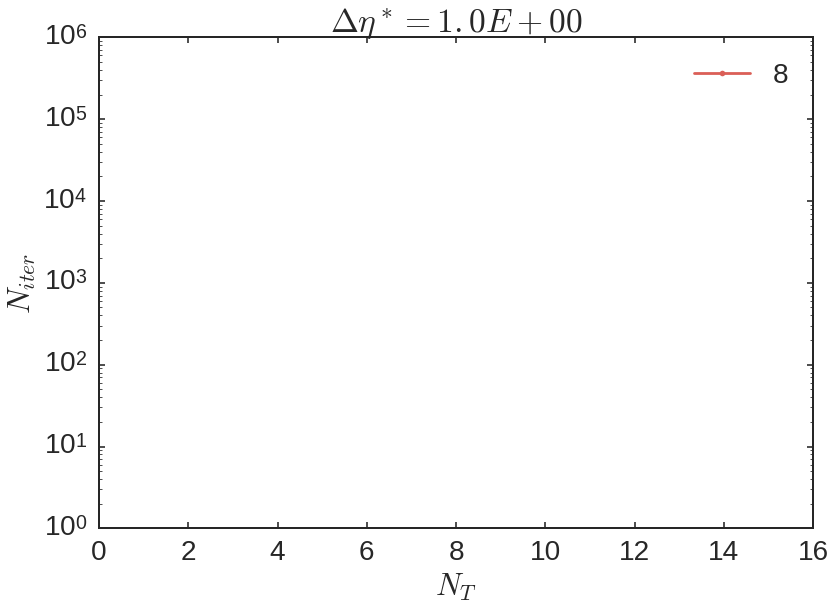

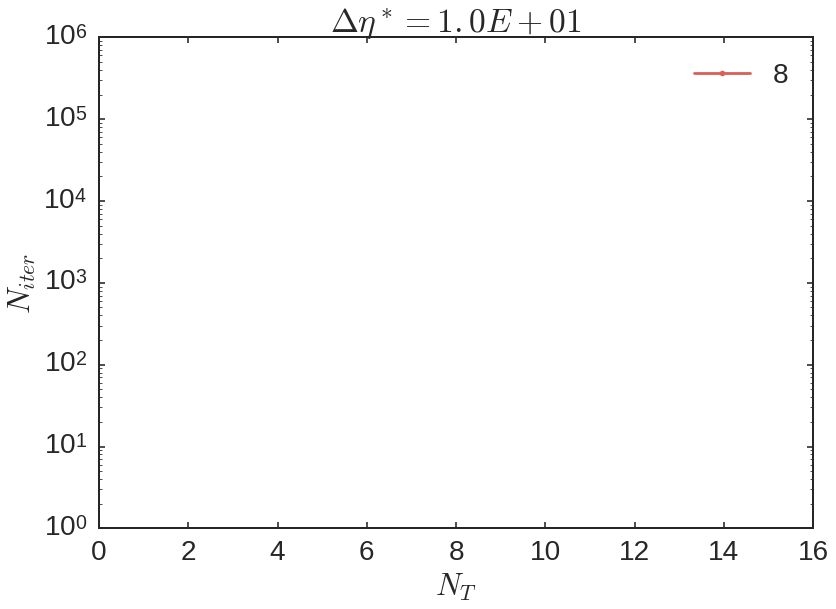

In [30]:


func = lambda x, mu, sigma : 0.5*(1-sp.special.erf((x-mu) / sigma / np.sqrt(2)))

for eta, group0 in df_agg.groupby('eta'):

    palette = it.cycle(sns.color_palette())

    fig, ax1 = plt.subplots()
    
    for NN, group1 in group0.groupby('NN'):

    #     if NN > 128:
    #         continue

    #     index = NN_list.index(NN)

        color = next(palette)

        NT = np.array(group1['NTS'])

        niter = np.array(group1['niter'])


    #     ax1.plot(np.linspace(0, 200, 1000) / NB, func(np.linspace(0, 200, 1000), rhoc_list[index], width_list[index]), color=color)

        ax1.plot(NT, niter, ".-", label="{:}".format(int(NN)), 
                     color=color)





    ax1.legend(loc="upper right")
    ax1.set_xlabel(r'$N_T$')
    ax1.set_ylabel(r'$N_{iter}$')
#     ax1.set_xlim(0, 40)
    ax1.set_ylim(1e0, 1e6)
    ax1.set_yscale('log')
    ax1.set_title(r'$\Delta\eta^*={:.1E}$'.format(eta))

    # plt.savefig("prob_success_err.png")
    # plt.savefig("fsat_slice_2D.eps")

    plt.show()

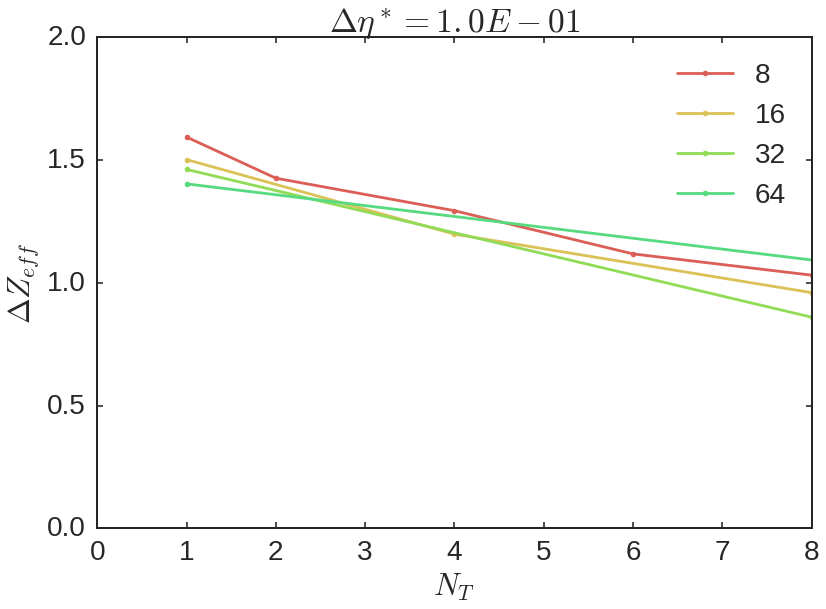

In [27]:


func = lambda x, mu, sigma : 0.5*(1-sp.special.erf((x-mu) / sigma / np.sqrt(2)))

for eta, group0 in df_agg.groupby('eta'):

    palette = it.cycle(sns.color_palette())

    fig, ax1 = plt.subplots()
    
    for NN, group1 in group0.groupby('NN'):

    #     if NN > 128:
    #         continue

    #     index = NN_list.index(NN)

        color = next(palette)

        NT = np.array(group1['NTS'])

        NR = np.array(group1['NR'])
        NE = np.array(group1['NE'])
        
        DZ = 2.0 * (NE - NR) / NN - 2.0 * (2 - 1.0 * 2 / NN)

    #     ax1.plot(np.linspace(0, 200, 1000) / NB, func(np.linspace(0, 200, 1000), rhoc_list[index], width_list[index]), color=color)

        ax1.plot(NT, DZ, ".-", label="{:}".format(int(NN)), 
                     color=color)





    ax1.legend(loc="upper right")
    ax1.set_xlabel(r'$N_T$')
    ax1.set_ylabel(r'$\Delta Z_{eff}$')
    ax1.set_ylim(0, 2)
    ax1.set_xlim(0, 8)
#     ax1.set_ylim(1e0, 1e6)
#     ax1.set_yscale('log')
    ax1.set_title(r'$\Delta\eta^*={:.1E}$'.format(eta))

    # plt.savefig("prob_success_err.png")
    # plt.savefig("fsat_slice_2D.eps")

    plt.show()

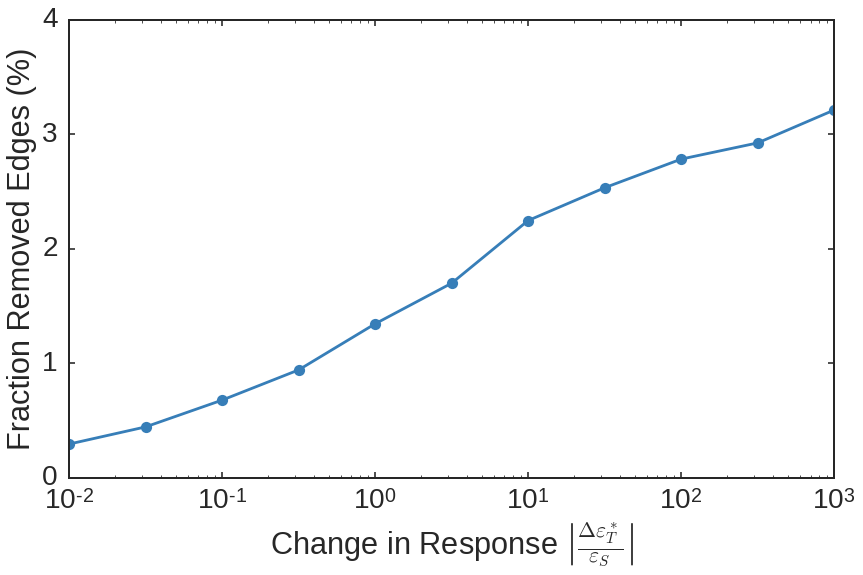

In [10]:

fig, ax1 = plt.subplots()

    
eta = np.array(df_agg[df_agg.NR > 0]['eta'])  
NR = np.array(df_agg[df_agg.NR > 0]['rhoR'])*100
NR_err = np.array(df_agg[df_agg.NR > 0]['rhoR_err'])*100
    
    
    
ax1.errorbar(eta, NR, yerr=NR_err, fmt="o-", color="#377eb8")
    
          
# ax1.legend(loc="upper right")
ax1.set_xlabel(r'Change in Response $\left|\frac{\Delta\varepsilon^*_T}{\varepsilon_S}\right|$')
ax1.set_ylabel(r'Fraction Removed Edges (%)')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_xlim(1e-2, 1e3)
ax1.set_ylim(0,4)
ax1.set_yticks(np.linspace(0, 4, 5))

plt.tight_layout()

plt.savefig("disc_rem_bonds.svg")

plt.show()

In [74]:
with tarfile.open(directory+"sim_files.tar", 'r') as tar:

    i = 0
    
    for member in tar.getmembers():
        
        if i % 1000 == 0:
            print i
        
        
        pkl_file = tar.extractfile(member)
        
        data = pickle.load(pkl_file)
        
        if data['eta'] in set([1e-1]):
            tar.extract(member, path="/data1/home/rocks/data/sat_transition/tune_disc_edge_2D_1")
            
        i += 1
        
        
print "Complete"      

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
Complete


In [129]:
NN_list = [8, 16, 32, 64, 128, 256, 512, 1024]
NREC_list = np.arange(32)
Lp_list = [-1.0]

eta_list = {}
for n in NN_list:
    eta_list[n] = [1e-1, 1e0]

    
NDIV = 1
NTS_list = {}
for NN in NN_list:
    tmp1 = []
    tmp2 = 2**np.arange(0, int(np.log2(NN))+1)
    for i in range(NDIV):
        tmp1 = np.copy(tmp2)
        tmp2 = []
        for i in range(len(tmp1)-1):
            tmp2.append(tmp1[i])
            if tmp1[i+1] > tmp1[i] + 1:
                tmp2.append((tmp1[i+1] + tmp1[i]) / 2)
        tmp2.append(tmp1[-1])
    NTS_list[NN] = tmp2
    

print NTS_list[8]

[1, 2, 3, 4, 6, 8]
